# Advanced Data Analysis

## Data Analysis: 2017

- Specifically analyse the energy consumption data for student households
- Look at households with consistent data in 2017
- Carry out descriptive statistical analysis on the energy consumption
- Carry out inferential statistical analysis on the energy consumption and household information (survey data)

### Setup

In [1]:
# Standard imports

import logging
from itertools import combinations

import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import (
    kendalltau,
    kruskal,
    mannwhitneyu,
    normaltest,
    shapiro,
    spearmanr,
)
from statsmodels.stats.multitest import multipletests

In [2]:
# Create Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, surpress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37181,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:42929,Total threads: 2
Dashboard: http://127.0.0.1:34491/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:37265,


### Load the data

Load the datasets to analyse the data

- Student Household IDs
- Summary of missing periods in energy consumption for each student household
- Student household energy consumption (Period: 2016-12-31 to 2018-12-30)
- Student household survey information

In [3]:
# Load extracted student BMG IDs
student_household = pd.read_csv(
    "../data/csv/student/student_household_bmgid_v1.csv",
    usecols=["BMG_ID"],
    index_col=False,
)

# Load the cleaning summary of energy data
student_energy_summary = pd.read_csv(
    "../data/csv/student/missing_days_summary_v1.csv"
)

# Load cleaned student energy data
student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part"
)
student_energy["recorded_timestamp"] = dd.to_datetime(
    student_energy["recorded_timestamp"]
)
# Exclusion dates
date_exclusion = pd.to_datetime("2016-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

date_exclusion = pd.to_datetime("2018-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]
date_exclusion = pd.to_datetime("2019-01-01")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

# Load cleaned student survey information
student_survey = pd.read_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv"
)
student_survey["BMG_ID"] = student_survey["BMG_ID"].astype("string")
student_survey.rename(columns={"BMG_ID": "bmg_id"}, inplace=True)

### Isolate households

- Isolate households with less than 5% missing data
- Isolate energy data for 2017

In [4]:
"""
Filter the student energy dataset further to
only identify those household IDs with less than 5% consecutive missing data in 2017.
"""

ids = student_energy_summary[
    (student_energy_summary["longest_missing_streak_2017"] <= 18)
]["bmg_id"]
print(len(ids))
print(ids)

315
1      A1956623744
3      A2956646445
4      A4956611998
10     A2956615457
11     A2956624999
          ...     
616    A2956618535
620    b1956610992
622    A4956614146
624    A1956640676
626    A2956642373
Name: bmg_id, Length: 315, dtype: object


In [5]:
# Filter the student energy information
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.year == 2017
]
student_energy = student_energy[student_energy["bmg_id"].isin(ids)]
print(len(student_energy))

114975


### Descriptive Statistical Analysis

In [6]:
# Analysis of Energy Data
# Target variable: energy
# Population: Student households

student_energy = student_energy.reset_index(drop=True)

print("\nEnergy data\n")
print(student_energy.info())
print(student_energy.head())
print(student_energy.describe().compute())


Energy data

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 3 entries, recorded_timestamp to energy
dtypes: datetime64[ns](1), float64(1), string(1)None
  recorded_timestamp       bmg_id  energy
0         2017-01-01  A1956623744  16.965
1         2017-01-02  A1956623744  19.728
2         2017-01-03  A1956623744  15.264
3         2017-01-04  A1956623744  18.874
4         2017-01-05  A1956623744  16.430
        recorded_timestamp         energy
count               114975  114548.000000
min    2017-01-01 00:00:00       0.000000
25%    2017-04-02 00:00:00       8.215000
50%    2017-07-02 00:00:00      12.066000
75%    2017-10-01 00:00:00      23.046000
max    2017-12-31 00:00:00     197.431000
mean                   NaN      12.304752
std                    NaN      10.625707


### Aggregated statistics

- To carry out inferential statistical analysis, we aggregate the energy consumption usage
    - Per household
    - Per month
    - Per year
- Energy statistics
    - Total Energy
    - Mean Energy
    - Median Energy
    - Minimum Energy
    - Maximum Energy
    - Standard Deviation   


Energy Statistic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bmg_id         3780 non-null   string 
 1   year           3780 non-null   int32  
 2   month          3780 non-null   int32  
 3   Total Energy   3780 non-null   float64
 4   Mean Energy    3780 non-null   float64
 5   Median Energy  3780 non-null   float64
 6   Min Energy     3780 non-null   float64
 7   Max Energy     3780 non-null   float64
 8   Std Energy     3780 non-null   float64
dtypes: float64(6), int32(2), string(1)
memory usage: 277.4 KB
None
        bmg_id  year  month  Total Energy  Mean Energy  Median Energy  \
0  A1956623744  2017      7       350.290    11.299677        10.5550   
1  A4956611998  2017     10        92.139     2.972226         2.6390   
2  A4956612213  2017      2       231.346     8.262357         7.9295   
3  A3956620191  2017      7    

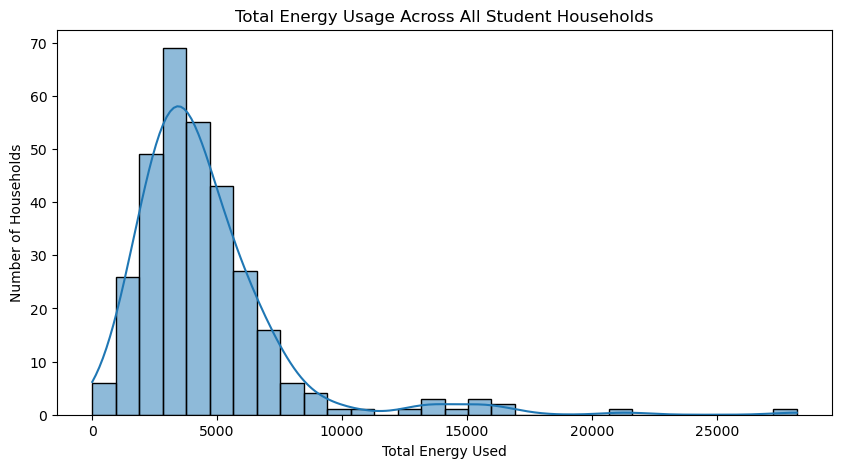

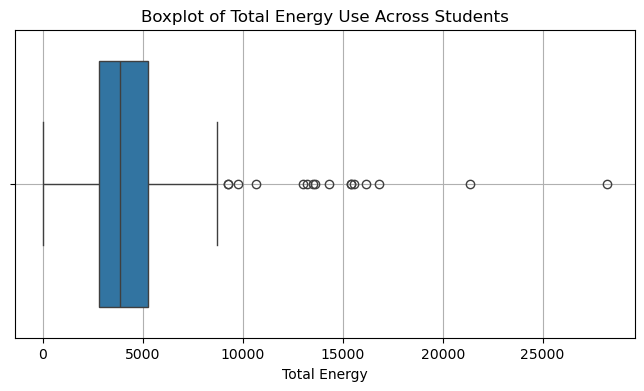

<Figure size 600x600 with 0 Axes>

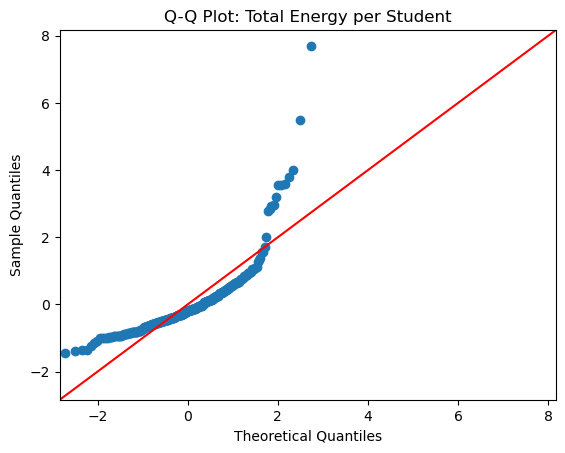


Total Energy per Student Summary:
count      315.000000
mean      4474.554679
std       3083.611632
min          0.548000
25%       2798.069000
50%       3847.033000
75%       5272.939000
max      28202.730000
Name: Total Energy, dtype: float64

Shapiro-Wilk Test: stat=0.7365, p=4.895e-22
The energy usage is not a normal distribution.
D'Agostino-Pearson Test: stat=246.5445, p=2.908e-54
The energy usage is not a normal distribution.


In [7]:
# Create a new dataframe with the energy consumption statistics
# for each student household

student_energy_statistics = pd.DataFrame()
student_energy_statistics["bmg_id"] = (
    student_energy["bmg_id"].unique().compute()
)

student_energy = student_energy.assign(
    year=student_energy["recorded_timestamp"].dt.year,
    month=student_energy["recorded_timestamp"].dt.month,
)

student_energy_statistics = (
    student_energy.groupby(["bmg_id", "year", "month"])
    .agg(
        **{
            "Total Energy": pd.NamedAgg(column="energy", aggfunc="sum"),
            "Mean Energy": pd.NamedAgg(column="energy", aggfunc="mean"),
            "Median Energy": pd.NamedAgg(column="energy", aggfunc="median"),
            "Min Energy": pd.NamedAgg(column="energy", aggfunc="min"),
            "Max Energy": pd.NamedAgg(column="energy", aggfunc="max"),
            "Std Energy": pd.NamedAgg(column="energy", aggfunc="std"),
        }
    )
    .compute()
    .reset_index()
)

print("\nEnergy Statistic\n")
print(student_energy_statistics.info())
print(student_energy_statistics.head())
print(student_energy_statistics.describe())


# Visualise the total energy distribution in 2017
# We are interested in understanding the energy usage over time (Monthly energy consumption over the two-year period)
# 1. Total energy use across all student households
total_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Total Energy"]
    .sum()
    .reset_index()
    .rename(columns={"Total Energy": "Total Energy"})
)

# Plot: Histogram of total energy usage across households
plt.figure(figsize=(10, 5))
sns.histplot(total_energy_per_student["Total Energy"], bins=30, kde=True)
plt.title("Total Energy Usage Across All Student Households")
plt.xlabel("Total Energy Used")
plt.ylabel("Number of Households")
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=total_energy_per_student["Total Energy"])
plt.title("Boxplot of Total Energy Use Across Students")
plt.grid(True)
plt.show()

# Q-Q plot for yearly total energy
plt.figure(figsize=(6, 6))
sm.qqplot(total_energy_per_student["Total Energy"], line="45", fit=True)
plt.title("Q-Q Plot: Total Energy per Student")
plt.show()

# Summary statistics
print("\nTotal Energy per Student Summary:")
print(total_energy_per_student["Total Energy"].describe())

# Normality tests
stat, p = shapiro(total_energy_per_student["Total Energy"])
print(f"\nShapiro-Wilk Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

stat, p = normaltest(total_energy_per_student["Total Energy"])
print(f"D'Agostino-Pearson Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

**Inferences**

- From the above histograms, Q-Q plots and box plots, we can visually see that the energy distribution across all student households is right-tailed or skewed.

- From the descriptive statistics, we see that the mode > median> mean. From the Shapiro-Wilk and D'Agostino-Pearson, we see that the distribution is not normal. 

- Therefore, to further carry out inferential statistical tests, we must use non-parametric testing. 

- The inferential statistical analysis is undertaken to understand the impacts of various household parameters, such as the number of bedrooms, appliances, etc., on the energy consumption of a student household.

### Isolate Survey Households

- Isolate the survey data for the required student households
- Use the median energy (a better indicator for right-tailed data) for inferential analysis
- Survey metrics:
    - Household Ownership
    - Landlord Type        
    - Green Energy         
    - Economy System Type             
    - Gas Supply           
    - Smart Meter          
    - Meter Reading Frequency 
    - Primary Heating      
    - EV                   
    - Property Type        
    - Occupancy
    - Main Heating System  
    - Water Heating System 
    - Appliances           
    - Number of Appliances 
     

In [8]:
# Filter the student household survey to reflect the student households
# in the energy data. This ensures the population is the same.
student_ids = student_energy["bmg_id"].unique().compute()
student_survey = student_survey[
    student_survey["bmg_id"].isin(student_ids.str[-9:])
]
id_map = pd.DataFrame({"last9": student_ids.str[-9:], "full_id": student_ids})
student_survey = student_survey.merge(
    id_map, left_on="bmg_id", right_on="last9", how="left"
)
student_survey["bmg_id"] = student_survey["full_id"]
student_survey = student_survey.drop(columns=["last9", "full_id"])

print(student_survey.head())
print(student_survey.info())
print(student_survey.describe())

# Add the median energy and total usage across both years to the
# Survey data
median_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Median Energy"]
    .median()
    .reset_index()
)

print(median_energy_per_student)

# Combine the survey data with median energy usage (target variable)
student_survey = student_survey.merge(median_energy_per_student, on="bmg_id")
student_survey = student_survey.merge(total_energy_per_student, on="bmg_id")
print(student_survey.head())

        bmg_id  Occupancy Household Ownership        Landlord Type  \
0  A3956610266        2.0                Rent              Council   
1  a4956610365        2.0                Rent  Housing association   
2  B4956610646        2.0                Rent              Council   
3  B4956610753        2.0                Rent              Council   
4  A2956610843        2.0            Mortgage              Unknown   

  Green Energy   Eco Type Gas Supply              Smart Meter  \
0      Unknown  Economy 7      Mains                  Unknown   
1      Unknown    Unknown      Mains                       No   
2           No         No      Mains                       No   
3           No         No      Mains  Smart electricity meter   
4          Yes    Unknown      Mains                  Unknown   

  Meter Reading Frequency Primary Heating  EV  Property Type  \
0             When billed      Gas boiler  No  Semi detached   
1       Electricity bills      Gas boiler  No  Semi detached

### Inferential Statistics

- For categorical data
    - Kruskall Wallis Test
    - Mann-Whitney U Pairwise Testing
- For continuous data
    - Spearman's Correlation

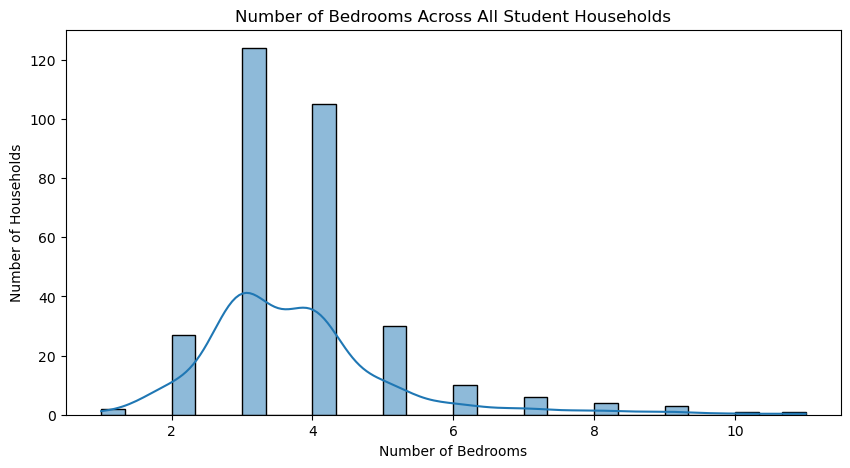

Kruskal-Wallis statistic: 32.5564, p-value: 0.0001
There is a statistically significant difference in median energy usage.
    Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
11      2.0      4.0        757.0  0.000197           0.010813   
13      2.0      6.0         26.0  0.000207           0.011371   
21      3.0      6.0        217.0  0.000655           0.036014   
12      2.0      5.0        213.0  0.002209           0.121502   
19      3.0      4.0       5180.0  0.007782           0.427995   
28      4.0      6.0        258.0  0.008163           0.448989   
4       1.0      6.0          0.0  0.030303           1.000000   
0       1.0      2.0         19.0  0.541872           1.000000   
7       1.0      9.0          0.0  0.200000           1.000000   
6       1.0      8.0          2.0  0.533333           1.000000   
5       1.0      7.0          2.0  0.285714           1.000000   
8       1.0     10.0          0.0  0.666667           1.000000   
10      2.0      3.

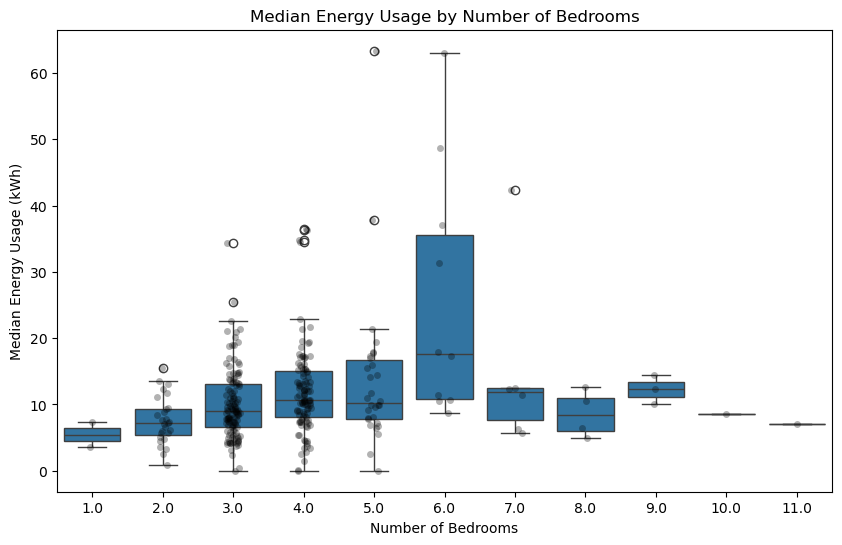

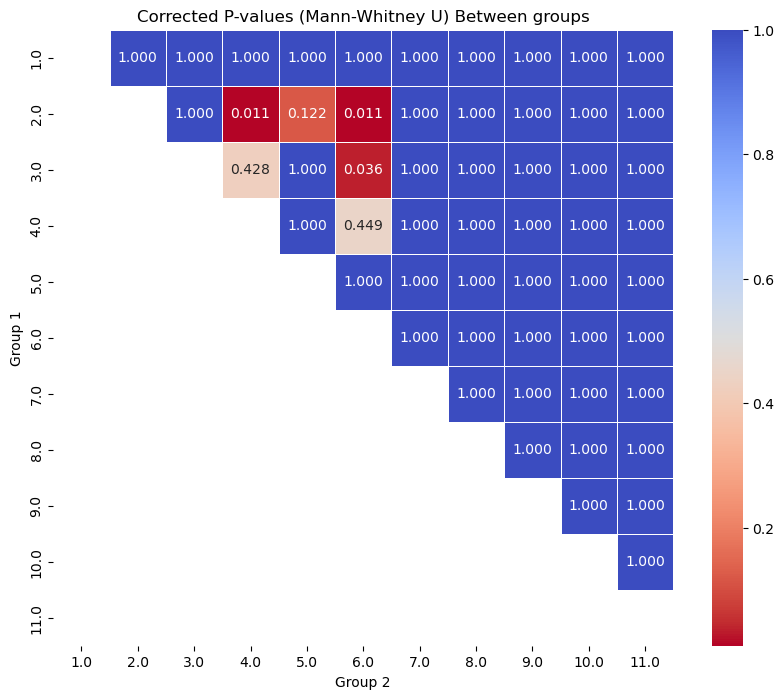

In [9]:
# Number of Bedrooms
# Visualise the distribution of households with each bedroom
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Number of bedrooms"], bins=30, kde=True)
plt.title("Number of Bedrooms Across All Student Households")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Households")
plt.show()

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Number of bedrooms"] == i]["Median Energy"]
    for i in range(1, 10)
    if not student_survey[student_survey["Number of bedrooms"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
bedroom_groups = sorted(student_survey["Number of bedrooms"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(bedroom_groups, 2):
    data1 = student_survey[student_survey["Number of bedrooms"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Number of bedrooms"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Number of bedrooms", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Number of bedrooms",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Number of Bedrooms")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Number of Bedrooms")
plt.show()

# Create an empty DataFrame to store corrected p-values
bedroom_levels = sorted(student_survey["Number of bedrooms"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=bedroom_levels, columns=bedroom_levels)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

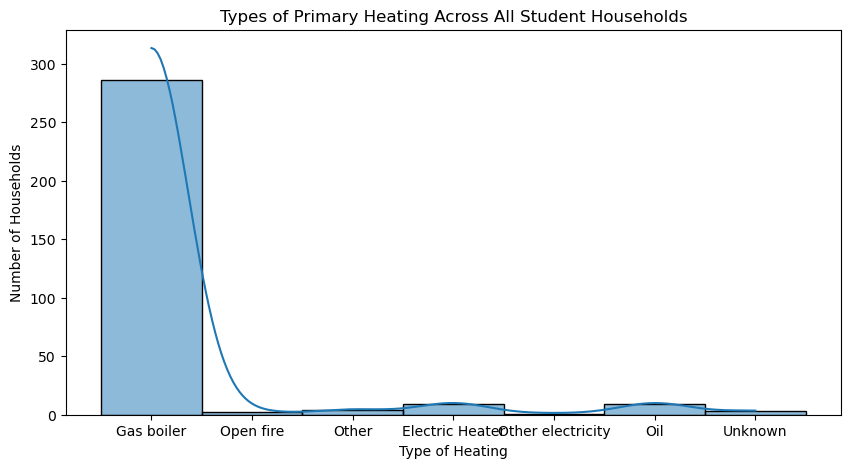

Kruskal-Wallis statistic: 10.6138, p-value: 0.1011
There is no statistically significant difference in median energy usage.
              Group 1            Group 2  U Statistic   P-value  \
6          Gas boiler                Oil        518.0  0.002289   
1     Electric Heater                Oil         17.0  0.042260   
2     Electric Heater          Open fire          6.0  0.581818   
0     Electric Heater         Gas boiler       1165.0  0.629672   
3     Electric Heater              Other         19.0  0.939860   
4     Electric Heater  Other electricity          3.0  0.800000   
5     Electric Heater            Unknown          9.0  0.481818   
7          Gas boiler          Open fire        240.0  0.708527   
8          Gas boiler              Other        630.0  0.739134   
9          Gas boiler  Other electricity         89.0  0.627178   
10         Gas boiler            Unknown        334.0  0.531357   
11                Oil          Open fire         14.0  0.327273   
12   

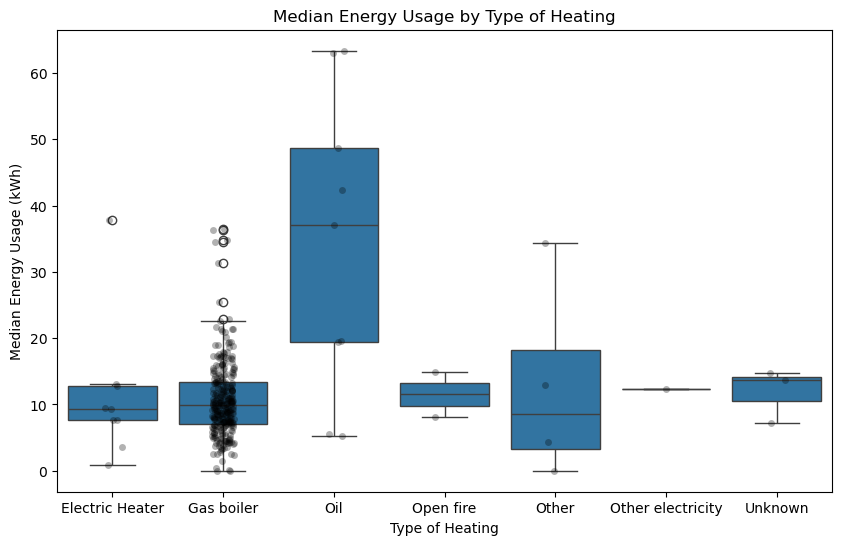

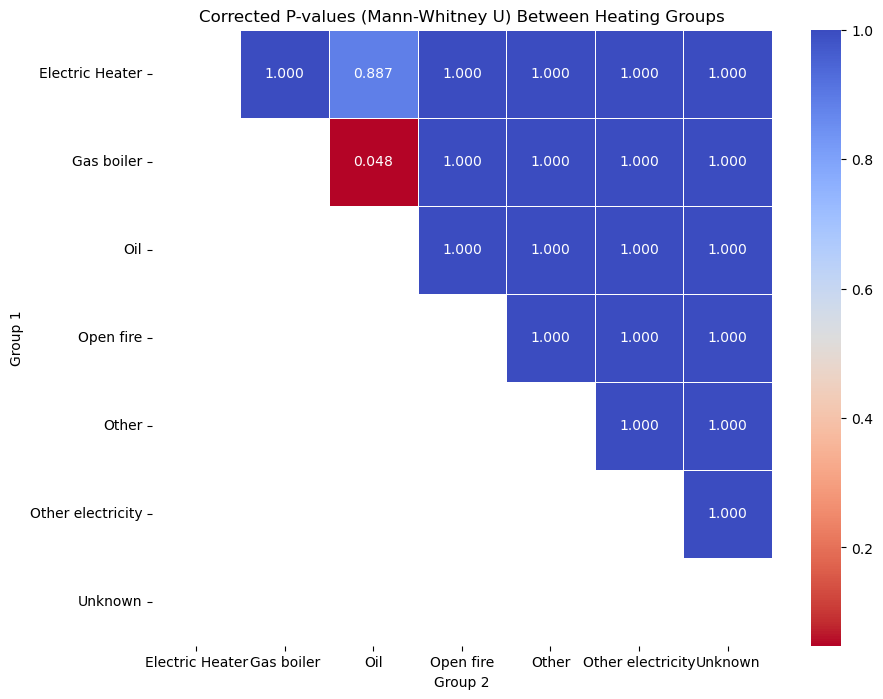

In [10]:
# Types of Primary Heating
# Visualise the distribution of households with each type of Primary Heating
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Primary Heating"], bins=30, kde=True)
plt.title("Types of Primary Heating Across All Student Households")
plt.xlabel("Type of Heating")
plt.ylabel("Number of Households")
plt.show()

student_survey["Primary Heating"] = student_survey["Primary Heating"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Primary Heating"] == i]["Median Energy"]
    for i in student_survey["Primary Heating"].cat.categories
    if not student_survey[student_survey["Primary Heating"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
heating_groups = sorted(student_survey["Primary Heating"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(heating_groups, 2):
    data1 = student_survey[student_survey["Primary Heating"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Primary Heating"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Primary Heating", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Primary Heating",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Heating")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Heating")
plt.show()

# Create an empty DataFrame to store corrected p-values
heating_types = sorted(student_survey["Primary Heating"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=heating_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Heating Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

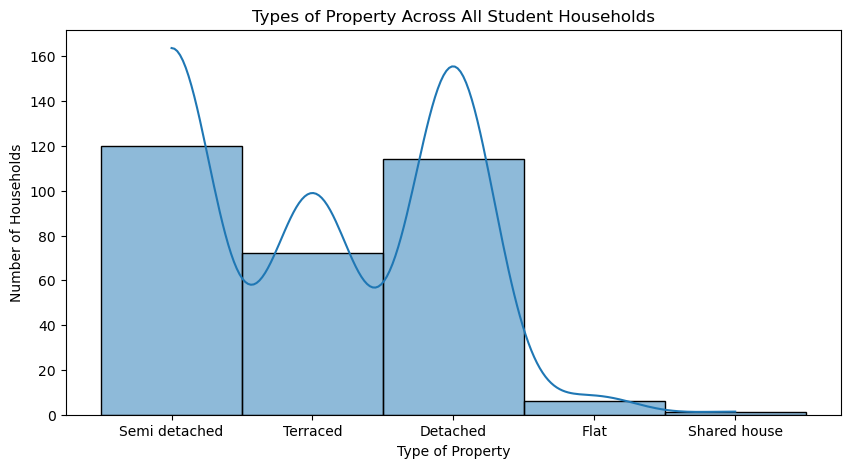

Kruskal-Wallis statistic: 17.2099, p-value: 0.0018
There is a statistically significant difference in median energy usage.
         Group 1        Group 2  U Statistic   P-value  Corrected P-value  \
3       Detached       Terraced       5305.0  0.000789           0.007888   
1       Detached  Semi detached       8466.0  0.001687           0.016865   
2       Detached   Shared house        111.0  0.069565           0.695652   
0       Detached           Flat        439.0  0.252210           1.000000   
4           Flat  Semi detached        343.0  0.853779           1.000000   
5           Flat   Shared house          6.0  0.285714           1.000000   
6           Flat       Terraced        214.0  0.978129           1.000000   
7  Semi detached   Shared house        114.0  0.115702           1.000000   
8  Semi detached       Terraced       4539.0  0.557777           1.000000   
9   Shared house       Terraced          8.0  0.246575           1.000000   

   Reject Null (α=0.10)  
3  

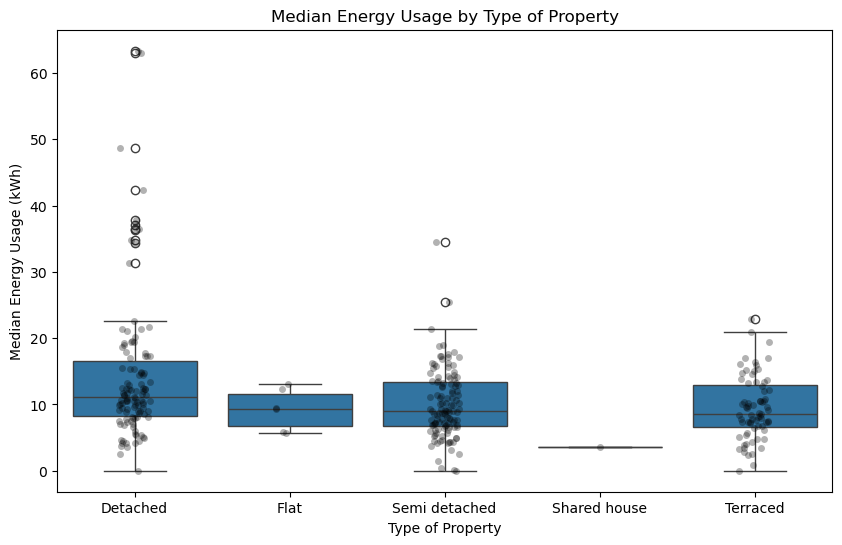

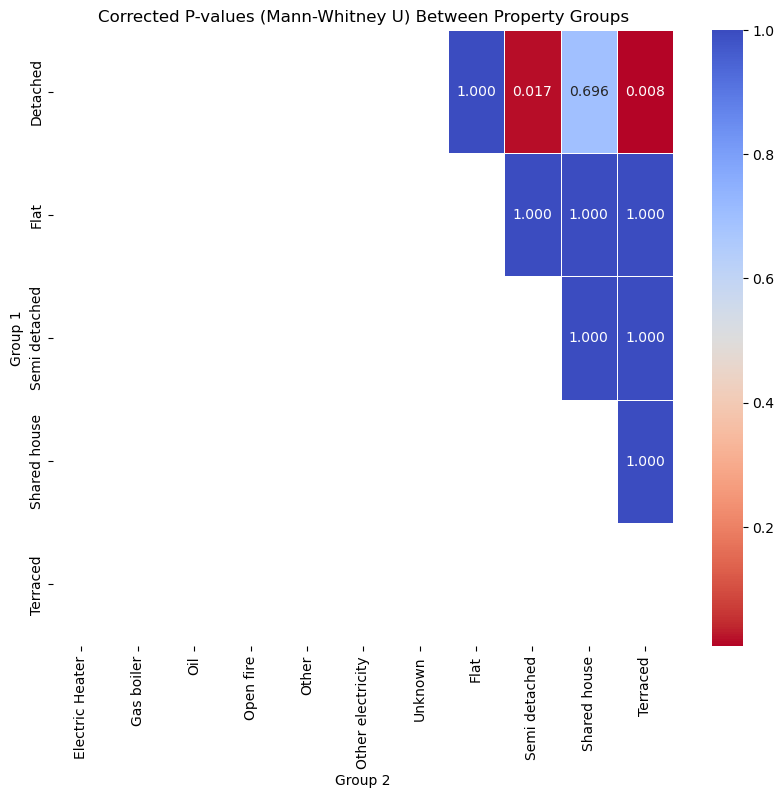

In [11]:
# Types of Property Type
# Visualise the distribution of households with each type of Property Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Property Type"], bins=30, kde=True)
plt.title("Types of Property Across All Student Households")
plt.xlabel("Type of Property")
plt.ylabel("Number of Households")
plt.show()

student_survey["Property Type"] = student_survey["Property Type"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Property Type"] == i]["Median Energy"]
    for i in student_survey["Property Type"].cat.categories
    if not student_survey[student_survey["Property Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
property_groups = sorted(student_survey["Property Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(property_groups, 2):
    data1 = student_survey[student_survey["Property Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Property Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Property Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Property Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
)
plt.title("Median Energy Usage by Type of Property")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Property")
plt.show()

# Create an empty DataFrame to store corrected p-values
property_types = sorted(student_survey["Property Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=property_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Property Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

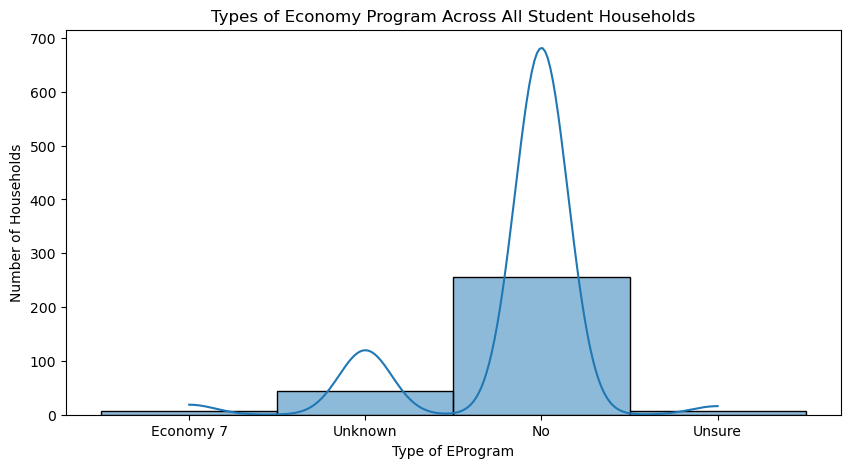

Kruskal-Wallis statistic: 3.0293, p-value: 0.3871
There is no statistically significant difference in median energy usage.
     Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
0  Economy 7       No       1057.0  0.426968                1.0   
1  Economy 7  Unknown        202.0  0.244003                1.0   
2  Economy 7   Unsure         31.0  0.180653                1.0   
3         No  Unknown       6343.0  0.279330                1.0   
4         No   Unsure        965.0  0.292081                1.0   
5    Unknown   Unsure        156.0  0.558155                1.0   

   Reject Null (α=0.10)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
5                 False  


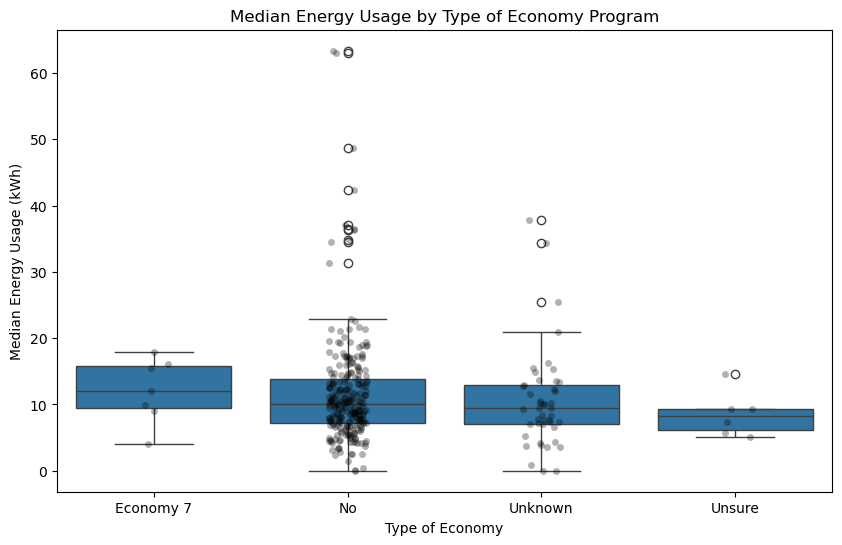

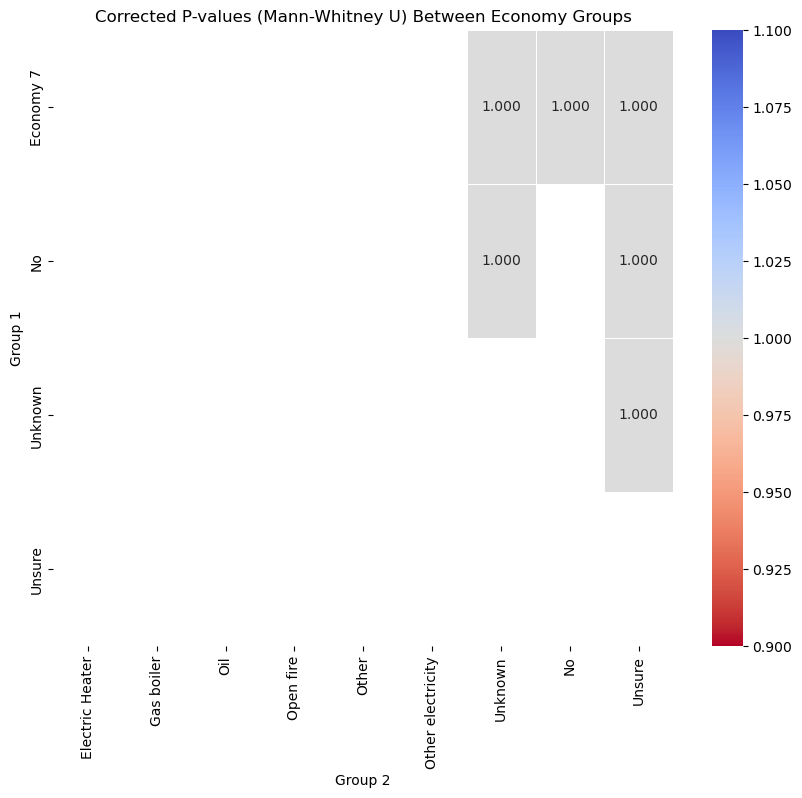

In [12]:
# Types of Eco Type
# Visualise the distribution of households with each type of Eco Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Eco Type"], bins=30, kde=True)
plt.title("Types of Economy Program Across All Student Households")
plt.xlabel("Type of EProgram")
plt.ylabel("Number of Households")
plt.show()

student_survey["Eco Type"] = student_survey["Eco Type"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Eco Type"] == i]["Median Energy"]
    for i in student_survey["Eco Type"].cat.categories
    if not student_survey[student_survey["Eco Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
economy_groups = sorted(student_survey["Eco Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(economy_groups, 2):
    data1 = student_survey[student_survey["Eco Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Eco Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Eco Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Eco Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Economy Program")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Eco Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Economy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

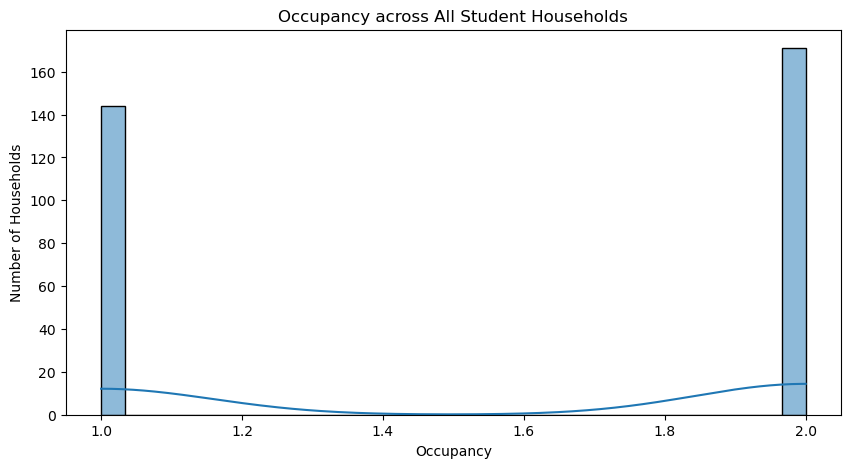

Kruskal-Wallis statistic: 5.0356, p-value: 0.0248
There is a statistically significant difference in median energy usage.
   Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
0      1.0      2.0      14119.0  0.024871           0.024871   

   Reject Null (α=0.10)  
0                  True  


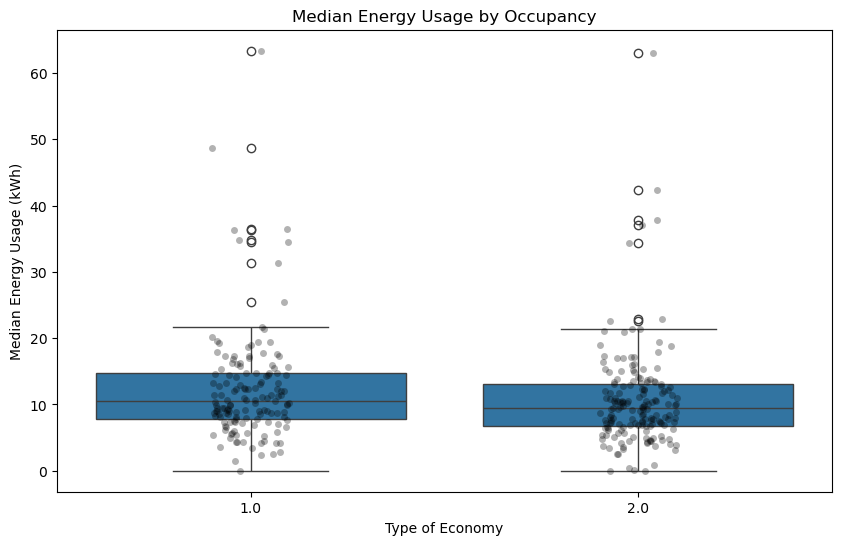

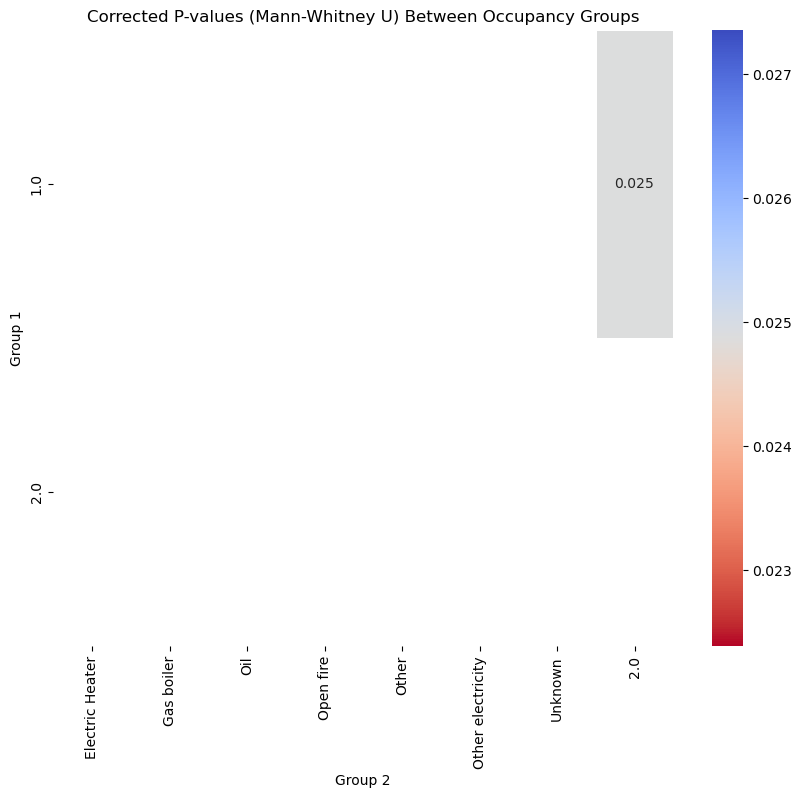

In [13]:
# Types of Occupancy
# Visualise the distribution of households with each type of Occupancy
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Occupancy"], bins=30, kde=True)
plt.title("Occupancy across All Student Households")
plt.xlabel("Occupancy")
plt.ylabel("Number of Households")
plt.show()

student_survey["Occupancy"] = student_survey["Occupancy"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Occupancy"] == i]["Median Energy"]
    for i in student_survey["Occupancy"].cat.categories
    if not student_survey[student_survey["Occupancy"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
occupancy_groups = sorted(student_survey["Occupancy"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(occupancy_groups, 2):
    data1 = student_survey[student_survey["Occupancy"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Occupancy"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Occupancy", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Occupancy",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Occupancy")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Occupancy"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Occupancy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

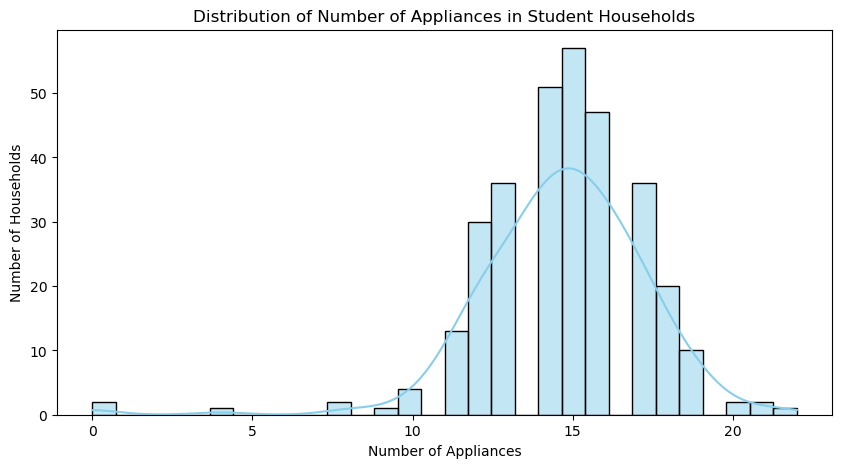

/tmp/ipykernel_8799/1485460987.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


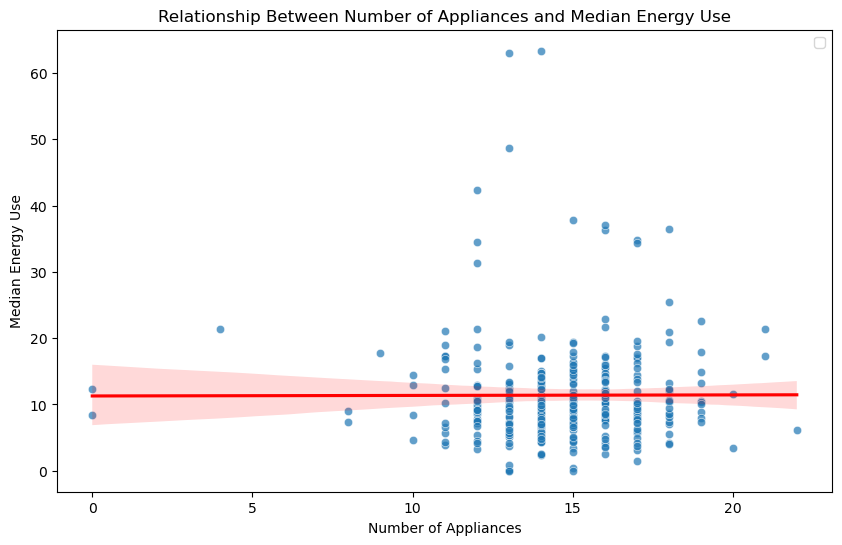

Spearman Correlation: 0.055
P-value: 0.3310
There is no statistically significant correlation.


In [14]:
# Histogram: Distribution of number of appliances
plt.figure(figsize=(10, 5))
sns.histplot(
    student_survey["Number of Appliances"], bins=30, kde=True, color="skyblue"
)
plt.title("Distribution of Number of Appliances in Student Households")
plt.xlabel("Number of Appliances")
plt.ylabel("Number of Households")
plt.show()

# Scatterplot: Median Energy vs. Number of Appliances
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=student_survey, x="Number of Appliances", y="Median Energy", alpha=0.7
)
sns.regplot(  # Optional: add a trend line
    data=student_survey,
    x="Number of Appliances",
    y="Median Energy",
    scatter=False,
    color="red",
    line_kws={"label": "Linear Trend"},
)
plt.title("Relationship Between Number of Appliances and Median Energy Use")
plt.xlabel("Number of Appliances")
plt.ylabel("Median Energy Use")
plt.legend()
plt.show()

# Spearman's correlation
stat, pvalue = spearmanr(
    student_survey["Median Energy"], student_survey["Number of Appliances"]
)
print(f"Spearman Correlation: {stat:.3f}")
print(f"P-value: {pvalue:.4f}")

if pvalue < 0.10:
    print("There is a statistically significant correlation.")
else:
    print("There is no statistically significant correlation.")

In [15]:
client.shutdown()

## Data Analysis: 2018


- Specifically analyse the energy consumption data for student households
- Look at households with consistent data in 2018
- Carry out descriptive statistical analysis on the energy consumption
- Carry out inferential statistical analysis on the energy consumption and household information (survey data)

### Setup

In [16]:
# Standard imports

import logging
from itertools import combinations

import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import (
    kendalltau,
    kruskal,
    mannwhitneyu,
    normaltest,
    shapiro,
    spearmanr,
)
from statsmodels.stats.multitest import multipletests

In [17]:
# Create Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, surpress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44725,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:37725,Total threads: 2
Dashboard: http://127.0.0.1:43867/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:33505,


### Load the data

Load the datasets to analyse the data

- Student Household IDs
- Summary of missing periods in energy consumption for each student household
- Student household energy consumption (Period: 2016-12-31 to 2018-12-30)
- Student household survey information

In [18]:
# Load extracted student BMG IDs
student_household = pd.read_csv(
    "../data/csv/student/student_household_bmgid_v1.csv",
    usecols=["BMG_ID"],
    index_col=False,
)

# Load the cleaning summary of energy data
student_energy_summary = pd.read_csv(
    "../data/csv/student/missing_days_summary_v1.csv"
)

# Load cleaned student energy data
student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part"
)
student_energy["recorded_timestamp"] = dd.to_datetime(
    student_energy["recorded_timestamp"]
)
# Exclusion dates
date_exclusion = pd.to_datetime("2016-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

date_exclusion = pd.to_datetime("2018-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]
date_exclusion = pd.to_datetime("2019-01-01")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

# Load cleaned student survey information
student_survey = pd.read_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv"
)
student_survey["BMG_ID"] = student_survey["BMG_ID"].astype("string")
student_survey.rename(columns={"BMG_ID": "bmg_id"}, inplace=True)

### Isolate households

- Isolate households with less than 5% missing data
- Isolate energy data for 2018

In [19]:
"""
Filter the student energy dataset further to
only identify those household IDs with less than 5% consecutive missing data in 2018.
"""

ids = student_energy_summary[
    (student_energy_summary["longest_missing_streak_2018"] <= 18)
]["bmg_id"]
print(len(ids))
print(ids)

143
3      A2956646445
8      a1956661244
9      a2956638215
10     A2956615457
11     A2956624999
          ...     
596    A1956630979
597    A2956630747
604    A1956659294
624    A1956640676
626    A2956642373
Name: bmg_id, Length: 143, dtype: object


In [20]:
# Filter the student energy information
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.year == 2018
]
student_energy = student_energy[student_energy["bmg_id"].isin(ids)]
print(len(student_energy))

52052


### Descriptive Statistical Analysis

In [21]:
# Analysis of Energy Data
# Target variable: energy
# Population: Student households

student_energy = student_energy.reset_index(drop=True)

print("\nEnergy data\n")
print(student_energy.info())
print(student_energy.head())
print(student_energy.describe().compute())


Energy data

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 3 entries, recorded_timestamp to energy
dtypes: datetime64[ns](1), float64(1), string(1)None
  recorded_timestamp       bmg_id  energy
0         2018-01-01  A2956646445  24.946
1         2018-01-02  A2956646445   2.664
2         2018-01-03  A2956646445   2.588
3         2018-01-04  A2956646445   3.328
4         2018-01-05  A2956646445   4.267
        recorded_timestamp        energy
count                52052  51859.000000
min    2018-01-01 00:00:00      0.000000
25%    2018-04-01 18:00:00      7.559500
50%    2018-07-01 12:00:00     11.930000
75%    2018-09-30 06:00:00     20.961750
max    2018-12-30 00:00:00    751.235000
mean                   NaN     11.914027
std                    NaN     11.320664


### Aggregated statistics

- To carry out inferential statistical analysis, we aggregate the energy consumption usage
    - Per household
    - Per month
    - Per year
- Energy statistics
    - Total Energy
    - Mean Energy
    - Median Energy
    - Minimum Energy
    - Maximum Energy
    - Standard Deviation   


Energy Statistic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bmg_id         1716 non-null   string 
 1   year           1716 non-null   int32  
 2   month          1716 non-null   int32  
 3   Total Energy   1716 non-null   float64
 4   Mean Energy    1716 non-null   float64
 5   Median Energy  1716 non-null   float64
 6   Min Energy     1716 non-null   float64
 7   Max Energy     1716 non-null   float64
 8   Std Energy     1716 non-null   float64
dtypes: float64(6), int32(2), string(1)
memory usage: 126.0 KB
None
        bmg_id  year  month  Total Energy  Mean Energy  Median Energy  \
0  A2956629166  2018      6       285.029     9.500967         9.1405   
1  A2956625903  2018     12       319.921    10.664033        10.4000   
2  a2956659954  2018      2       285.366    10.191643        10.1030   
3  a2956619509  2018      1    

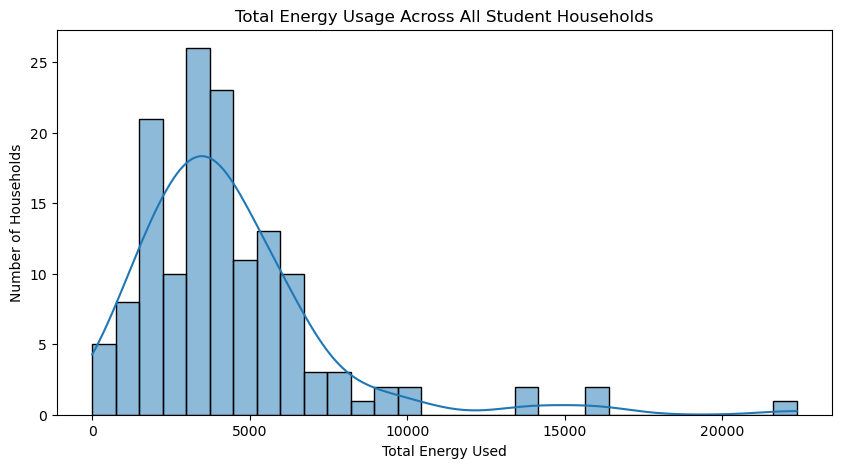

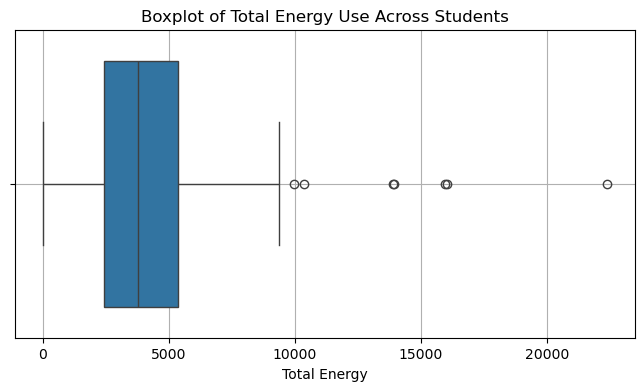

<Figure size 600x600 with 0 Axes>

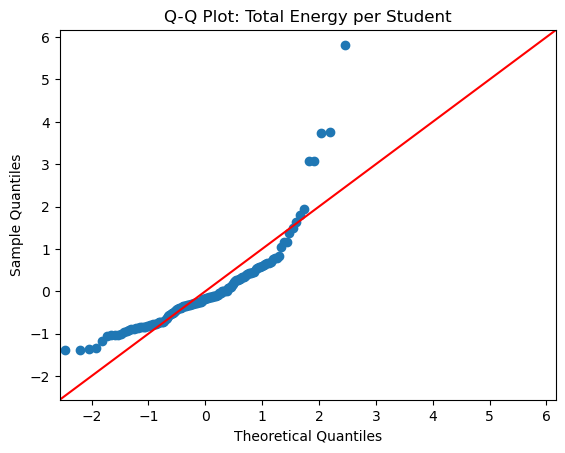


Total Energy per Student Summary:
count      143.000000
mean      4320.626210
std       3120.979139
min          0.489000
25%       2425.372000
50%       3761.056000
75%       5351.375000
max      22370.218000
Name: Total Energy, dtype: float64

Shapiro-Wilk Test: stat=0.7902, p=4.911e-13
The energy usage is not a normal distribution.
D'Agostino-Pearson Test: stat=99.9984, p=1.93e-22
The energy usage is not a normal distribution.


In [22]:
# Create a new dataframe with the energy consumption statistics
# for each student household

student_energy_statistics = pd.DataFrame()
student_energy_statistics["bmg_id"] = (
    student_energy["bmg_id"].unique().compute()
)

student_energy = student_energy.assign(
    year=student_energy["recorded_timestamp"].dt.year,
    month=student_energy["recorded_timestamp"].dt.month,
)

student_energy_statistics = (
    student_energy.groupby(["bmg_id", "year", "month"])
    .agg(
        **{
            "Total Energy": pd.NamedAgg(column="energy", aggfunc="sum"),
            "Mean Energy": pd.NamedAgg(column="energy", aggfunc="mean"),
            "Median Energy": pd.NamedAgg(column="energy", aggfunc="median"),
            "Min Energy": pd.NamedAgg(column="energy", aggfunc="min"),
            "Max Energy": pd.NamedAgg(column="energy", aggfunc="max"),
            "Std Energy": pd.NamedAgg(column="energy", aggfunc="std"),
        }
    )
    .compute()
    .reset_index()
)

print("\nEnergy Statistic\n")
print(student_energy_statistics.info())
print(student_energy_statistics.head())
print(student_energy_statistics.describe())


# Visualise the total energy distribution in 2017
# We are interested in understanding the energy usage over time (Monthly energy consumption over the two-year period)
# 1. Total energy use across all student households
total_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Total Energy"]
    .sum()
    .reset_index()
    .rename(columns={"Total Energy": "Total Energy"})
)

# Plot: Histogram of total energy usage across households
plt.figure(figsize=(10, 5))
sns.histplot(total_energy_per_student["Total Energy"], bins=30, kde=True)
plt.title("Total Energy Usage Across All Student Households")
plt.xlabel("Total Energy Used")
plt.ylabel("Number of Households")
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=total_energy_per_student["Total Energy"])
plt.title("Boxplot of Total Energy Use Across Students")
plt.grid(True)
plt.show()

# Q-Q plot for yearly total energy
plt.figure(figsize=(6, 6))
sm.qqplot(total_energy_per_student["Total Energy"], line="45", fit=True)
plt.title("Q-Q Plot: Total Energy per Student")
plt.show()

# Summary statistics
print("\nTotal Energy per Student Summary:")
print(total_energy_per_student["Total Energy"].describe())

# Normality tests
stat, p = shapiro(total_energy_per_student["Total Energy"])
print(f"\nShapiro-Wilk Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

stat, p = normaltest(total_energy_per_student["Total Energy"])
print(f"D'Agostino-Pearson Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

**Inferences**

- From the above histograms, Q-Q plots and box plots, we can visually see that the energy distribution across all student households is right-tailed or skewed.

- From the descriptive statistics, we see that the mode > median> mean. From the Shapiro-Wilk and D'Agostino-Pearson, we see that the distribution is not normal. 

- Therefore, to further carry out inferential statistical tests, we must use non-parametric testing. 

- The inferential statistical analysis is undertaken to understand the impacts of various household parameters, such as the number of bedrooms, appliances, etc., on the energy consumption of a student household.

### Isolate Survey Households

- Isolate the survey data for the required student households
- Use the median energy (a better indicator for right-tailed data) for inferential analysis
- Survey metrics:
    - Household Ownership
    - Landlord Type        
    - Green Energy         
    - Economy System Type             
    - Gas Supply           
    - Smart Meter          
    - Meter Reading Frequency 
    - Primary Heating      
    - EV                   
    - Property Type        
    - Occupancy
    - Main Heating System  
    - Water Heating System 
    - Appliances           
    - Number of Appliances 
     

In [23]:
# Filter the student household survey to reflect the student households
# in the energy data. This ensures the population is the same.
student_ids = student_energy["bmg_id"].unique().compute()
student_survey = student_survey[
    student_survey["bmg_id"].isin(student_ids.str[-9:])
]
id_map = pd.DataFrame({"last9": student_ids.str[-9:], "full_id": student_ids})
student_survey = student_survey.merge(
    id_map, left_on="bmg_id", right_on="last9", how="left"
)
student_survey["bmg_id"] = student_survey["full_id"]
student_survey = student_survey.drop(columns=["last9", "full_id"])

print(student_survey.head())
print(student_survey.info())
print(student_survey.describe())

# Add the median energy and total usage across both years to the
# Survey data
median_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Median Energy"]
    .median()
    .reset_index()
)

print(median_energy_per_student)

# Combine the survey data with median energy usage (target variable)
student_survey = student_survey.merge(median_energy_per_student, on="bmg_id")
student_survey = student_survey.merge(total_energy_per_student, on="bmg_id")
print(student_survey.head())

        bmg_id  Occupancy Household Ownership Landlord Type Green Energy  \
0  A2956610843        2.0            Mortgage       Unknown          Yes   
1  A2956611200        1.0                Rent       Council           No   
2  A1956611573        1.0                 Own       Unknown           No   
3  A1956611583        2.0            Mortgage       Unknown           No   
4  A2956611616        1.0            Mortgage       Unknown           No   

    Eco Type Gas Supply Smart Meter Meter Reading Frequency Primary Heating  \
0    Unknown      Mains     Unknown    Asked to by provider      Gas boiler   
1  Economy 7      Mains          No               Regularly      Gas boiler   
2         No      Mains          No               Regularly      Gas boiler   
3         No      Mains          No             When billed      Gas boiler   
4         No      Mains          No             When billed      Gas boiler   

   EV  Property Type  Number of bedrooms  \
0  No  Semi detached    

### Inferential Statistics

- For categorical data
    - Kruskall Wallis Test
    - Mann-Whitney U Pairwise Testing
- For continuous data
    - Spearman's Correlation

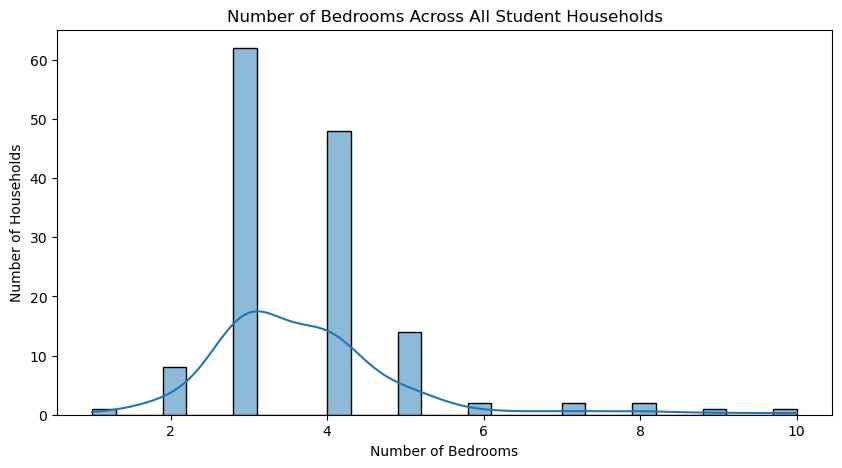

Kruskal-Wallis statistic: 19.9504, p-value: 0.0105
There is a statistically significant difference in median energy usage.
    Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
18      3.0      5.0        239.0  0.009154           0.411922   
19      3.0      6.0          0.0  0.017639           0.793753   
25      4.0      6.0          1.0  0.021327           0.959706   
0       1.0      2.0          1.0  0.444444           1.000000   
4       1.0      6.0          0.0  0.666667           1.000000   
1       1.0      3.0          9.0  0.237047           1.000000   
2       1.0      4.0          3.0  0.147168           1.000000   
3       1.0      5.0          1.0  0.266667           1.000000   
8       1.0     10.0          0.0  1.000000           1.000000   
9       2.0      3.0        223.0  0.651071           1.000000   
10      2.0      4.0        135.0  0.185852           1.000000   
11      2.0      5.0         23.0  0.024017           1.000000   
12      2.0      6.

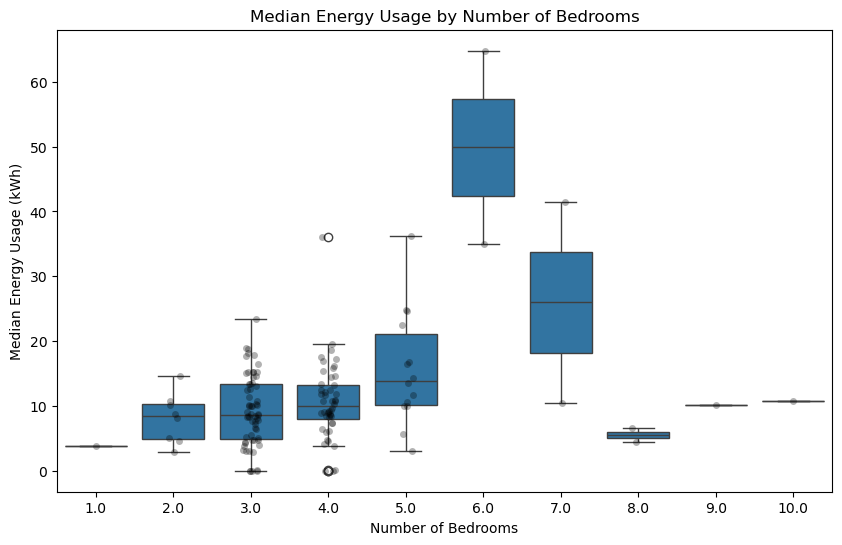

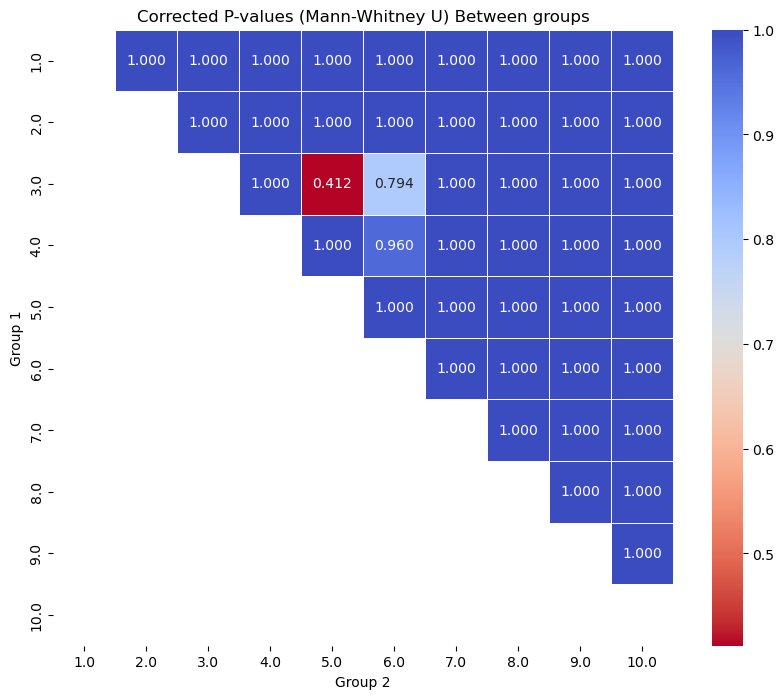

In [24]:
# Number of Bedrooms
# Visualise the distribution of households with each bedroom
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Number of bedrooms"], bins=30, kde=True)
plt.title("Number of Bedrooms Across All Student Households")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Households")
plt.show()

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Number of bedrooms"] == i]["Median Energy"]
    for i in range(1, 10)
    if not student_survey[student_survey["Number of bedrooms"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
bedroom_groups = sorted(student_survey["Number of bedrooms"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(bedroom_groups, 2):
    data1 = student_survey[student_survey["Number of bedrooms"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Number of bedrooms"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Number of bedrooms", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Number of bedrooms",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Number of Bedrooms")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Number of Bedrooms")
plt.show()

# Create an empty DataFrame to store corrected p-values
bedroom_levels = sorted(student_survey["Number of bedrooms"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=bedroom_levels, columns=bedroom_levels)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

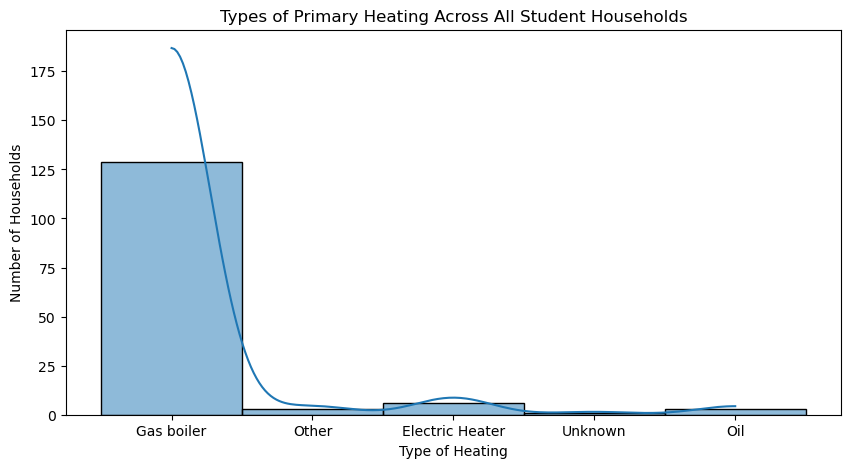

Kruskal-Wallis statistic: 8.7516, p-value: 0.0676
There is a statistically significant difference in median energy usage.
           Group 1     Group 2  U Statistic   P-value  Corrected P-value  \
4       Gas boiler         Oil          1.0  0.003371           0.033709   
1  Electric Heater         Oil          1.0  0.047619           0.476190   
2  Electric Heater       Other          7.0  0.714286           1.000000   
0  Electric Heater  Gas boiler        368.0  0.843413           1.000000   
3  Electric Heater     Unknown          3.0  1.000000           1.000000   
5       Gas boiler       Other        184.0  0.890696           1.000000   
6       Gas boiler     Unknown         77.0  0.749134           1.000000   
7              Oil       Other          9.0  0.100000           1.000000   
8              Oil     Unknown          3.0  0.500000           1.000000   
9            Other     Unknown          2.0  1.000000           1.000000   

   Reject Null (α=0.10)  
4              

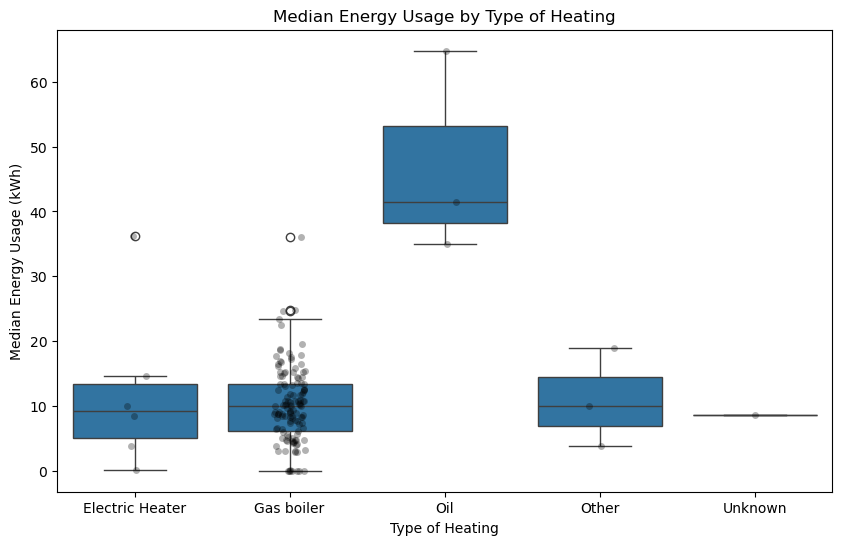

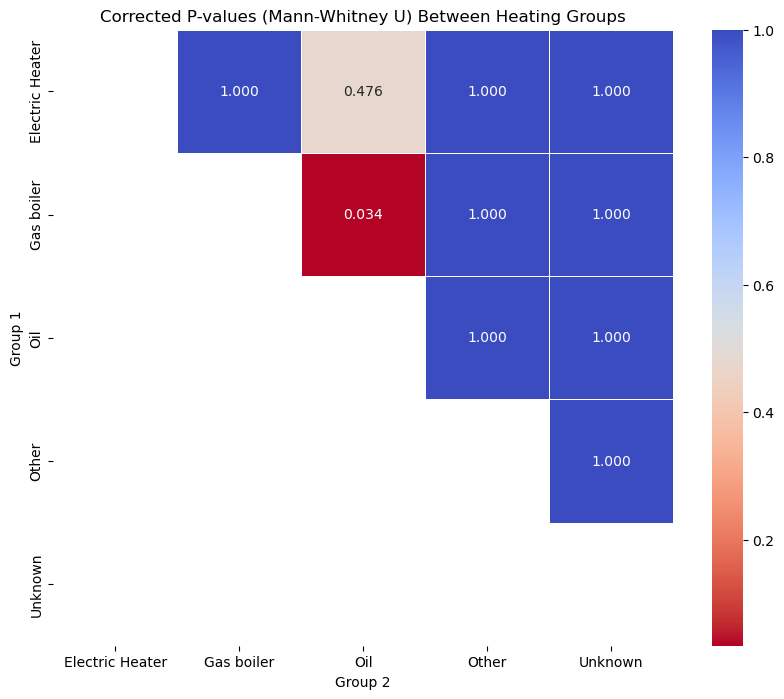

In [25]:
# Types of Primary Heating
# Visualise the distribution of households with each type of Primary Heating
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Primary Heating"], bins=30, kde=True)
plt.title("Types of Primary Heating Across All Student Households")
plt.xlabel("Type of Heating")
plt.ylabel("Number of Households")
plt.show()

student_survey["Primary Heating"] = student_survey["Primary Heating"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Primary Heating"] == i]["Median Energy"]
    for i in student_survey["Primary Heating"].cat.categories
    if not student_survey[student_survey["Primary Heating"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
heating_groups = sorted(student_survey["Primary Heating"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(heating_groups, 2):
    data1 = student_survey[student_survey["Primary Heating"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Primary Heating"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Primary Heating", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Primary Heating",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Heating")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Heating")
plt.show()

# Create an empty DataFrame to store corrected p-values
heating_types = sorted(student_survey["Primary Heating"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=heating_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Heating Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

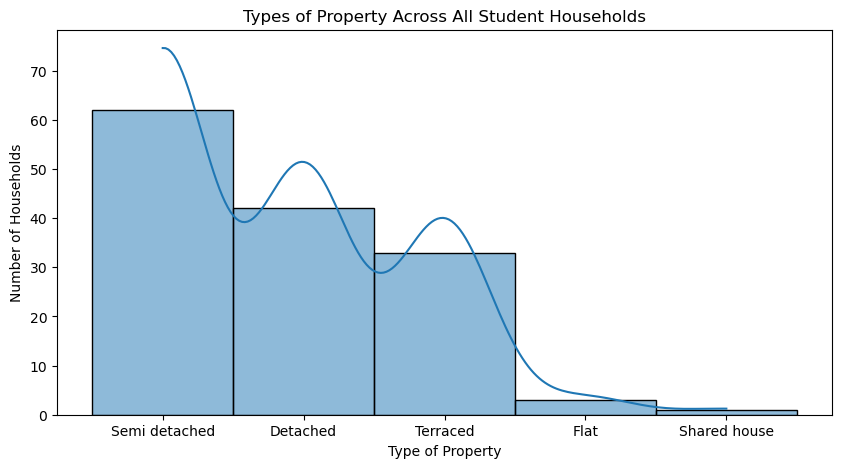

Kruskal-Wallis statistic: 4.2942, p-value: 0.3676
There is no statistically significant difference in median energy usage.
         Group 1        Group 2  U Statistic   P-value  Corrected P-value  \
0       Detached           Flat         86.0  0.305921                1.0   
1       Detached  Semi detached       1472.0  0.261463                1.0   
2       Detached   Shared house         37.0  0.211638                1.0   
3       Detached       Terraced        730.0  0.696840                1.0   
4           Flat  Semi detached         63.0  0.356354                1.0   
5           Flat   Shared house          2.0  1.000000                1.0   
6           Flat       Terraced         33.0  0.377311                1.0   
7  Semi detached   Shared house         57.0  0.160817                1.0   
8  Semi detached       Terraced        923.0  0.436726                1.0   
9   Shared house       Terraced          3.0  0.235294                1.0   

   Reject Null (α=0.10)  
0  

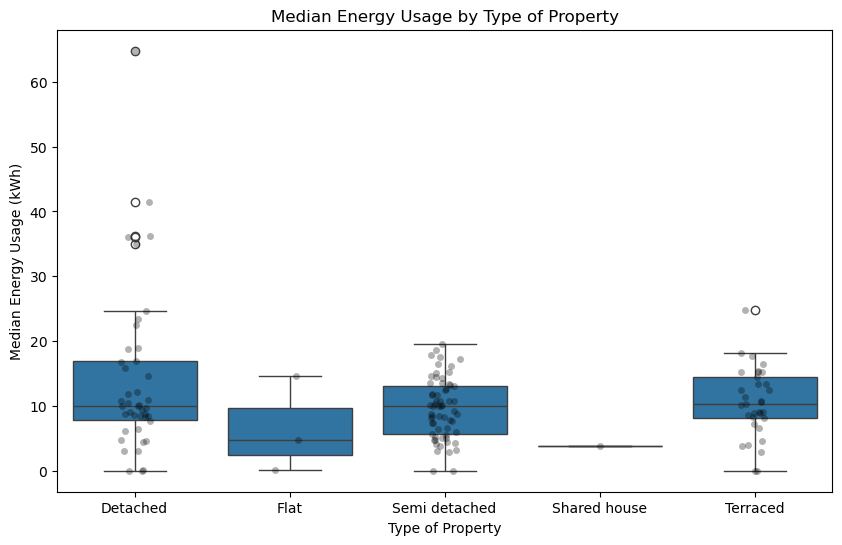

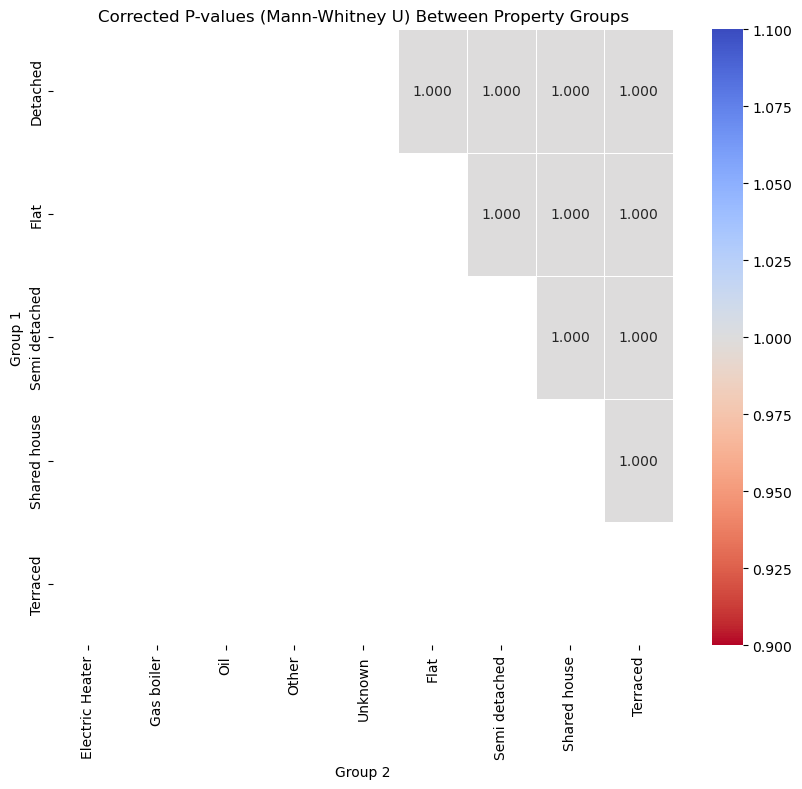

In [26]:
# Types of Property Type
# Visualise the distribution of households with each type of Property Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Property Type"], bins=30, kde=True)
plt.title("Types of Property Across All Student Households")
plt.xlabel("Type of Property")
plt.ylabel("Number of Households")
plt.show()

student_survey["Property Type"] = student_survey["Property Type"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Property Type"] == i]["Median Energy"]
    for i in student_survey["Property Type"].cat.categories
    if not student_survey[student_survey["Property Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
property_groups = sorted(student_survey["Property Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(property_groups, 2):
    data1 = student_survey[student_survey["Property Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Property Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Property Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Property Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
)
plt.title("Median Energy Usage by Type of Property")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Property")
plt.show()

# Create an empty DataFrame to store corrected p-values
property_types = sorted(student_survey["Property Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=property_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Property Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

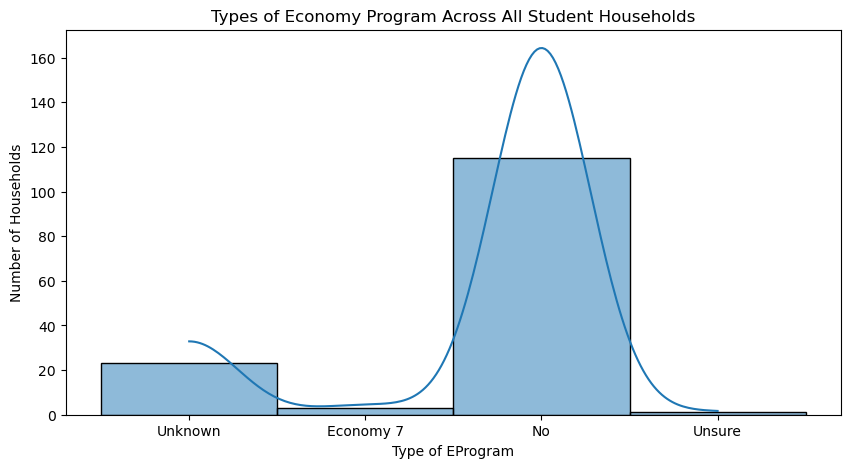

Kruskal-Wallis statistic: 1.6052, p-value: 0.6582
There is no statistically significant difference in median energy usage.
     Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
0  Economy 7       No        231.0  0.321385                1.0   
1  Economy 7  Unknown         45.0  0.441538                1.0   
2  Economy 7   Unsure          2.0  1.000000                1.0   
3         No  Unknown       1353.0  0.863912                1.0   
4         No   Unsure         29.0  0.403037                1.0   
5    Unknown   Unsure          8.0  0.750000                1.0   

   Reject Null (α=0.10)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
5                 False  


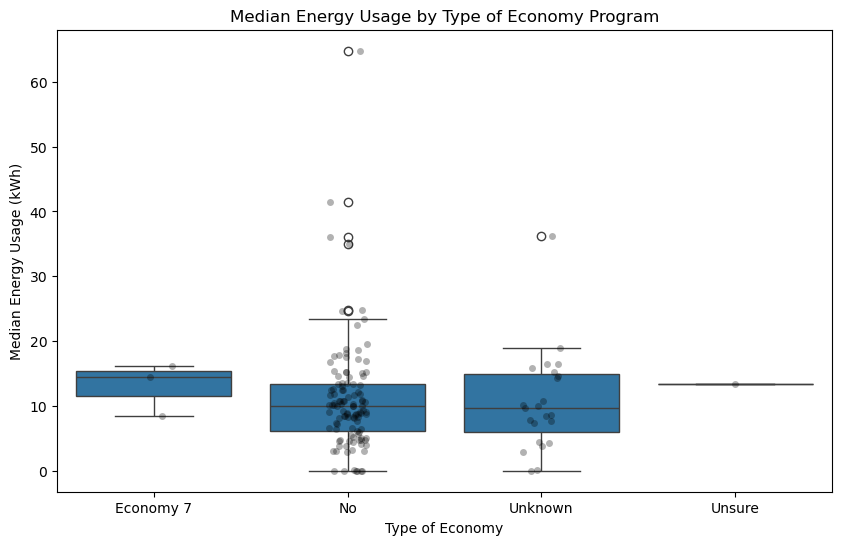

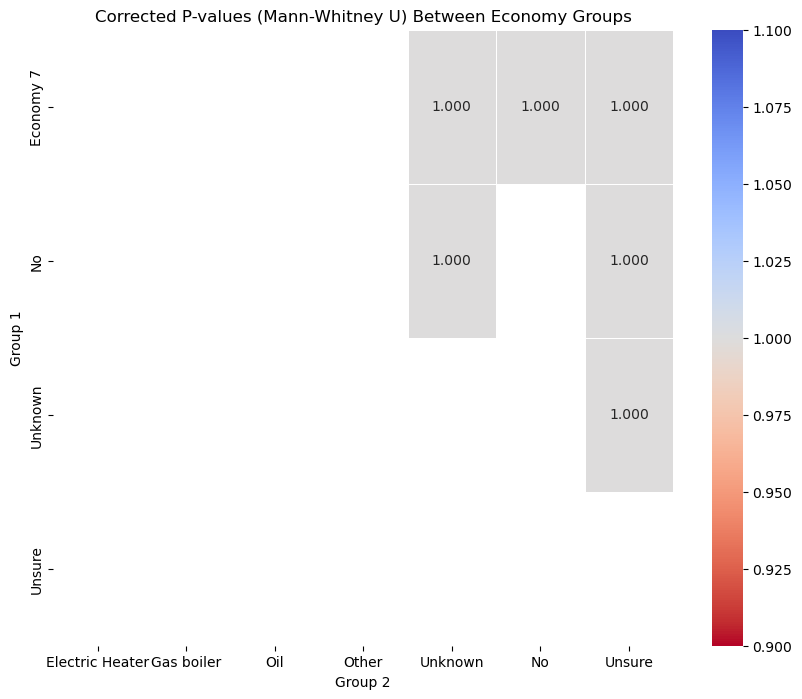

In [27]:
# Types of Eco Type
# Visualise the distribution of households with each type of Eco Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Eco Type"], bins=30, kde=True)
plt.title("Types of Economy Program Across All Student Households")
plt.xlabel("Type of EProgram")
plt.ylabel("Number of Households")
plt.show()

student_survey["Eco Type"] = student_survey["Eco Type"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Eco Type"] == i]["Median Energy"]
    for i in student_survey["Eco Type"].cat.categories
    if not student_survey[student_survey["Eco Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )
# Since p < 0.10, there is a statistical difference.
# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
economy_groups = sorted(student_survey["Eco Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(economy_groups, 2):
    data1 = student_survey[student_survey["Eco Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Eco Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Eco Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Eco Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Economy Program")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Eco Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Economy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

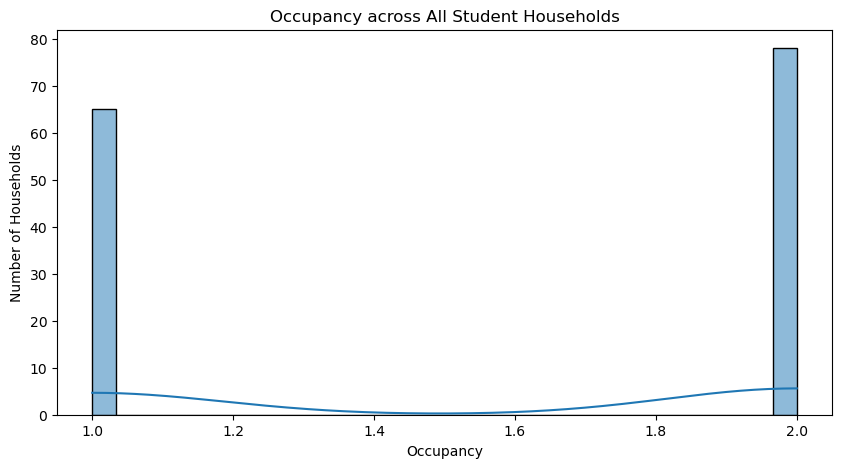

Kruskal-Wallis statistic: 0.6774, p-value: 0.4105
There is no statistically significant difference in median energy usage.
   Group 1  Group 2  U Statistic  P-value  Corrected P-value  \
0      1.0      2.0       2738.0  0.41165            0.41165   

   Reject Null (α=0.10)  
0                 False  


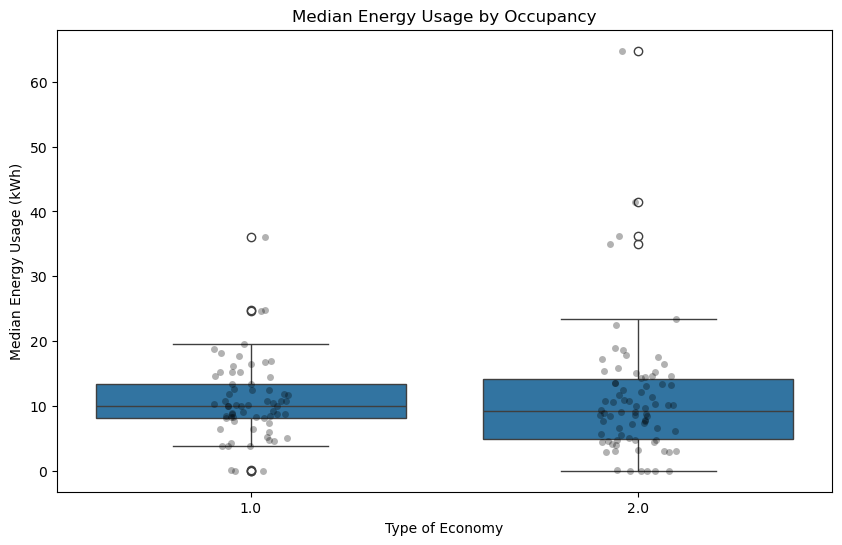

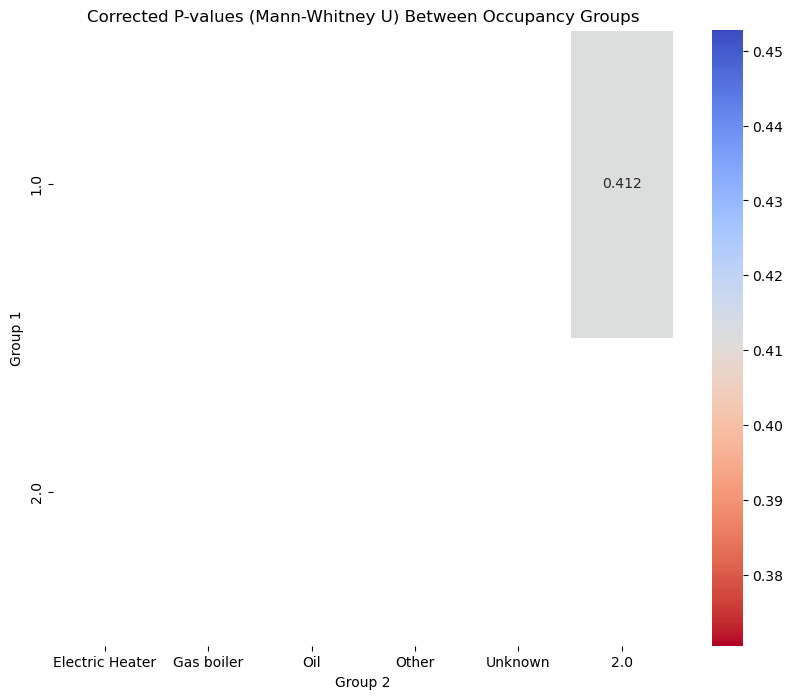

In [28]:
# Types of Occupancy
# Visualise the distribution of households with each type of Occupancy
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Occupancy"], bins=30, kde=True)
plt.title("Occupancy across All Student Households")
plt.xlabel("Occupancy")
plt.ylabel("Number of Households")
plt.show()

student_survey["Occupancy"] = student_survey["Occupancy"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Occupancy"] == i]["Median Energy"]
    for i in student_survey["Occupancy"].cat.categories
    if not student_survey[student_survey["Occupancy"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
occupancy_groups = sorted(student_survey["Occupancy"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(occupancy_groups, 2):
    data1 = student_survey[student_survey["Occupancy"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Occupancy"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Occupancy", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Occupancy",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Occupancy")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Occupancy"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Occupancy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

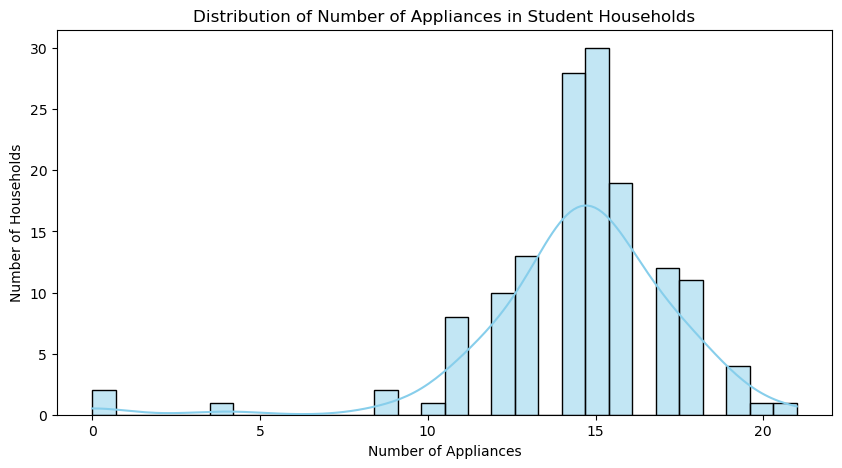

/tmp/ipykernel_8799/2442824697.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


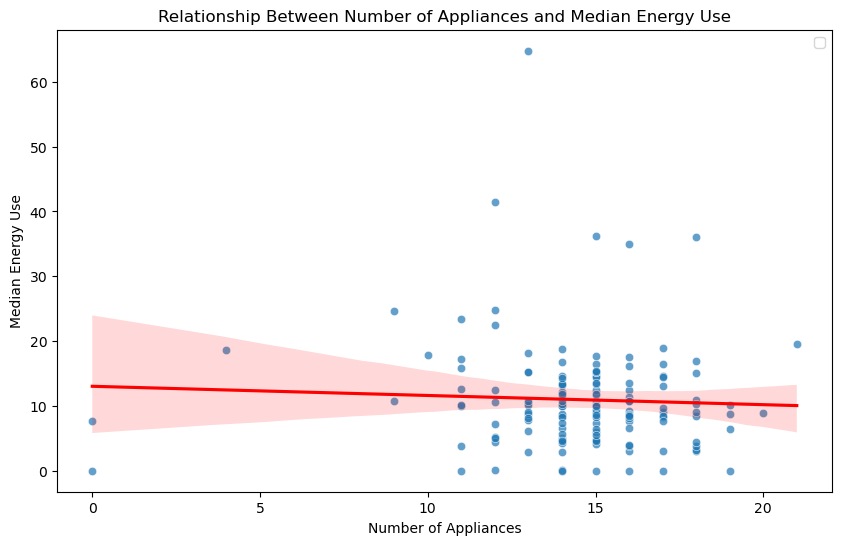

Spearman Correlation: -0.080
P-value: 0.3437
There is no statistically significant correlation.


In [29]:
# Histogram: Distribution of number of appliances
plt.figure(figsize=(10, 5))
sns.histplot(
    student_survey["Number of Appliances"], bins=30, kde=True, color="skyblue"
)
plt.title("Distribution of Number of Appliances in Student Households")
plt.xlabel("Number of Appliances")
plt.ylabel("Number of Households")
plt.show()

# Scatterplot: Median Energy vs. Number of Appliances
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=student_survey, x="Number of Appliances", y="Median Energy", alpha=0.7
)
sns.regplot(  # Optional: add a trend line
    data=student_survey,
    x="Number of Appliances",
    y="Median Energy",
    scatter=False,
    color="red",
    line_kws={"label": "Linear Trend"},
)
plt.title("Relationship Between Number of Appliances and Median Energy Use")
plt.xlabel("Number of Appliances")
plt.ylabel("Median Energy Use")
plt.legend()
plt.show()

# Spearman's correlation
stat, pvalue = spearmanr(
    student_survey["Median Energy"], student_survey["Number of Appliances"]
)
print(f"Spearman Correlation: {stat:.3f}")
print(f"P-value: {pvalue:.4f}")

# Optional interpretation
if pvalue < 0.10:
    print("There is a statistically significant correlation.")
else:
    print("There is no statistically significant correlation.")

In [30]:
client.shutdown()

## Data Analysis: 2017 & 2018 combined

- Specifically analyse the energy consumption data for student households
- Look at households with consistent data across both 2017 and 2018
- Carry out descriptive statistical analysis on the energy consumption
- Carry out inferential statistical analysis on the energy consumption and household information (survey data)

### Setup

In [31]:
# Standard imports

import logging
from itertools import combinations

import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import (
    kendalltau,
    kruskal,
    mannwhitneyu,
    normaltest,
    shapiro,
    spearmanr,
)
from statsmodels.stats.multitest import multipletests

In [32]:
# Create Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, surpress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36005,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:38595,Total threads: 2
Dashboard: http://127.0.0.1:45415/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:43043,


### Load the data

Load the datasets to analyse the data

- Student Household IDs
- Summary of missing periods in energy consumption for each student household
- Student household energy consumption (Period: 2016-12-31 to 2018-12-30)
- Student household survey information

In [33]:
# Load extracted student BMG IDs
student_household = pd.read_csv(
    "../data/csv/student/student_household_bmgid_v1.csv",
    usecols=["BMG_ID"],
    index_col=False,
)

# Load the cleaning summary of energy data
student_energy_summary = pd.read_csv(
    "../data/csv/student/missing_days_summary_v1.csv"
)

# Load cleaned student energy data
student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part"
)
student_energy["recorded_timestamp"] = dd.to_datetime(
    student_energy["recorded_timestamp"]
)
# Exclusion dates
date_exclusion = pd.to_datetime("2016-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

date_exclusion = pd.to_datetime("2018-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]
date_exclusion = pd.to_datetime("2019-01-01")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

# Load cleaned student survey information
student_survey = pd.read_csv(
    "../data/csv/student/student_survey_cleaned_v1.csv"
)
student_survey["BMG_ID"] = student_survey["BMG_ID"].astype("string")
student_survey.rename(columns={"BMG_ID": "bmg_id"}, inplace=True)

### Descriptive Statistical Analysis

In [34]:
# Understand each of the dataframes

print("Student household information")
print(student_household.info())
print(student_household.head())
print(student_household.describe())

print("\nStudent household energy summary")
print(student_energy_summary.info())
print(student_energy_summary.head())
print(student_energy_summary.describe())

print("\nStudent survey")
print(student_survey.info())
print(student_survey.head())
print(student_survey.describe())

print("\nEnergy data")
print(student_energy.info())
print(student_energy.head())
print(student_energy.describe().compute())

Student household information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   BMG_ID  565 non-null    int64
dtypes: int64(1)
memory usage: 4.5 KB
None
      BMG_ID
0  956610255
1  956611829
2  956612115
3  956613764
4  956614943
             BMG_ID
count  5.650000e+02
mean   9.566315e+08
std    1.507534e+04
min    9.566002e+08
25%    9.566190e+08
50%    9.566294e+08
75%    9.566409e+08
max    9.566632e+08

Student household energy summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   bmg_id                       631 non-null    object
 1   missing_days_2017            631 non-null    int64 
 2   longest_missing_streak_2017  631 non-null    int64 
 3   missing_days_2018            631

### Visualise and Analyse the Missing Data

- Understand the missing energy consumption data
    - In 2017
    - In 2018
    - In 2017 and 2018
- We require consistent data readings with low periods of perpetual loss. Specifically, we look to reduce the error margin by identifying data with less than 5% (18 days) of consecutively missing data.  

Number of households with less than 5% missing data in 2017: 315
Number of households with less than 5% missing data in 2018: 142
Number of households with less than 5% missing data in 2017 and 2018: 126
Number of households with less than 5% consecutive missing data in 2017: 315
Number of households with less than 5% consecutive missing data in 2018: 143
Number of households with less than 5% consecutive missing data in 2017 and 2018: 127


<Axes: title={'center': 'Consecutive Missing Energy Histogram 2018'}, xlabel='longest_missing_streak_2018', ylabel='Count'>

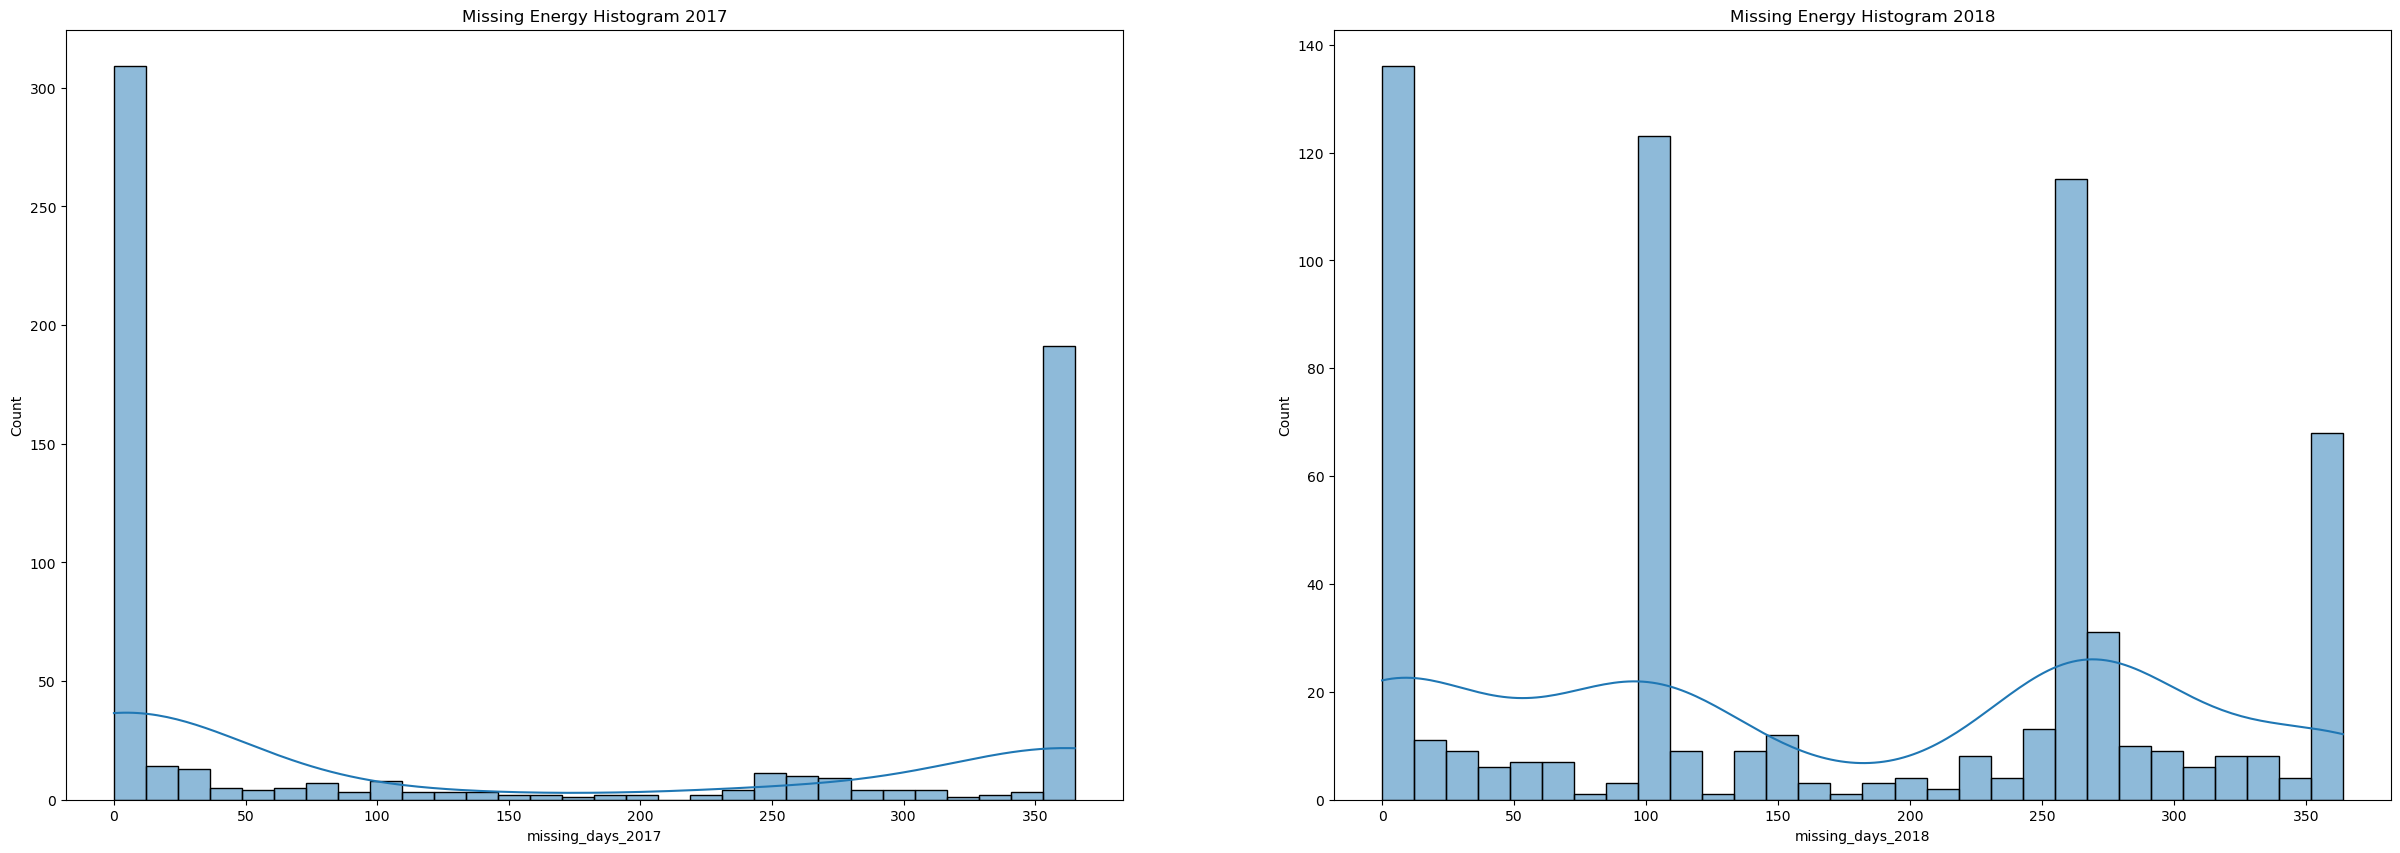

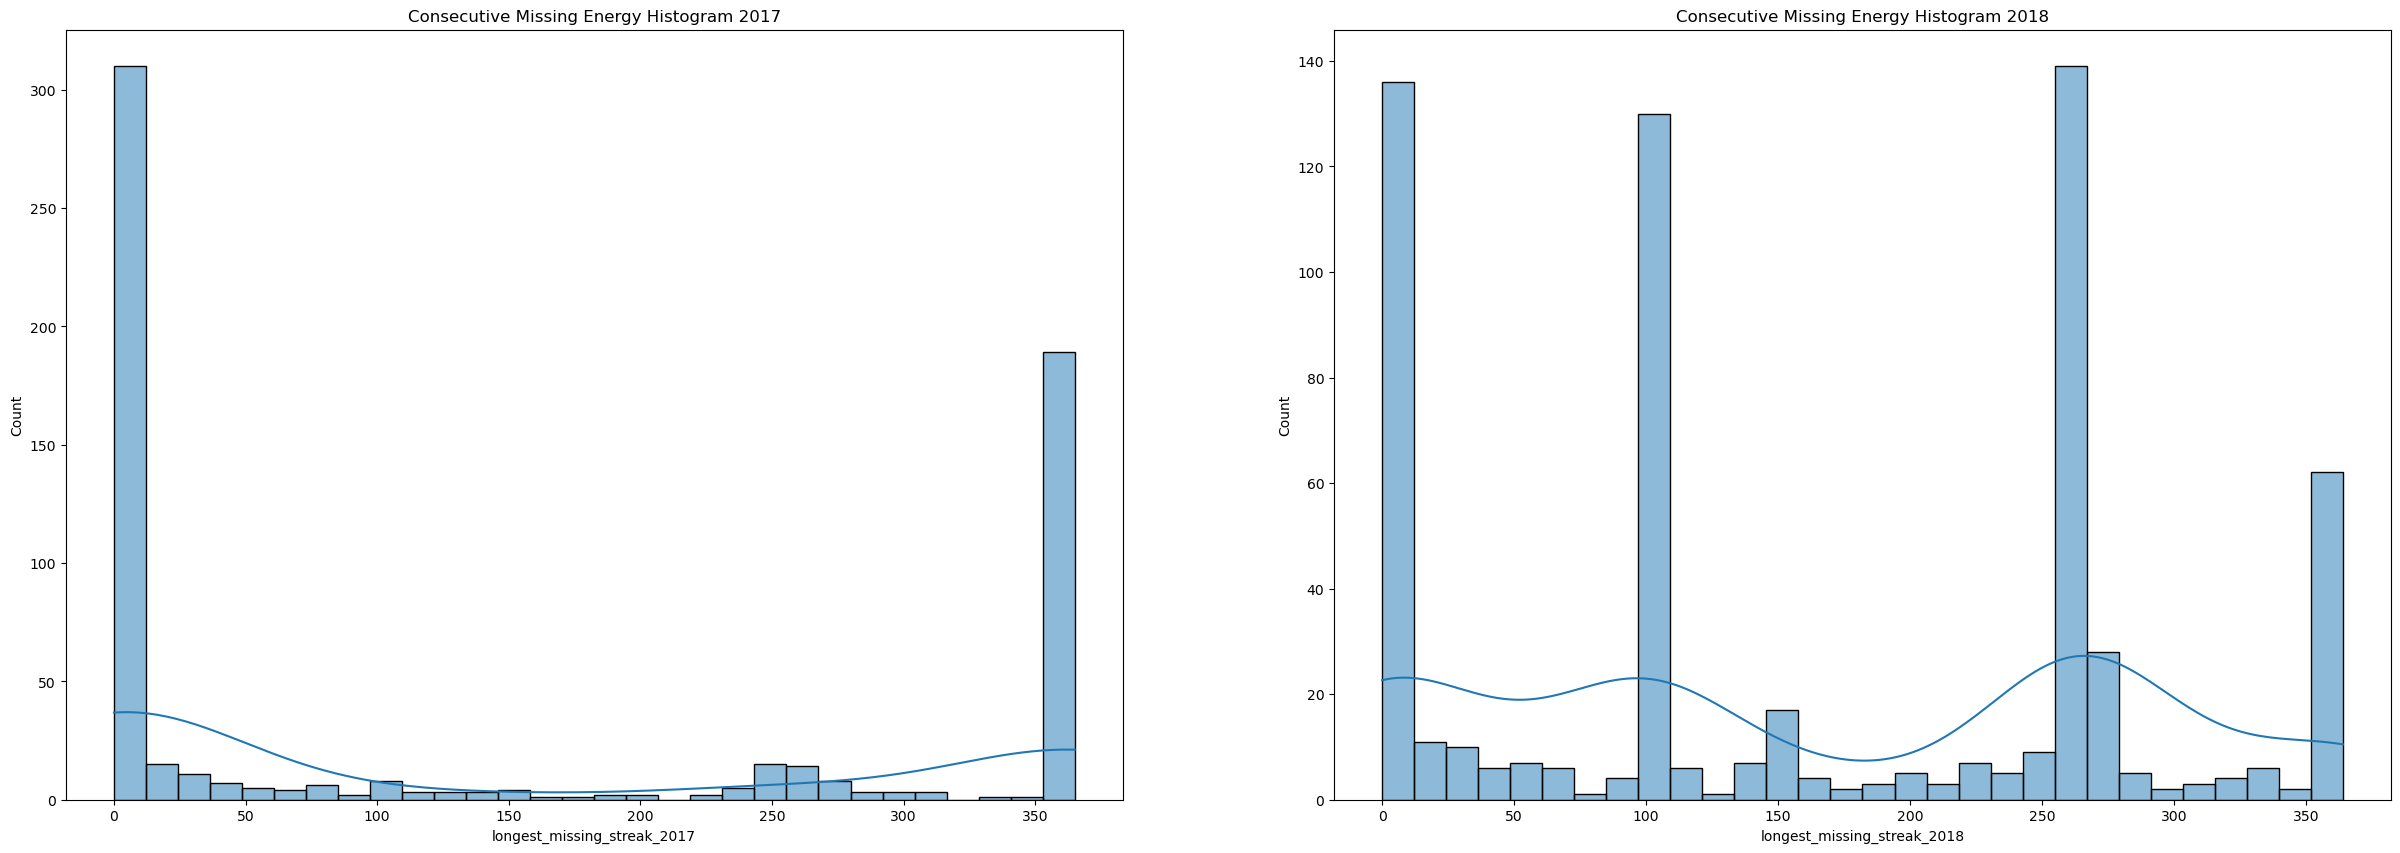

In [35]:
# Understand the missing data characteristics
# Check to see how many student households have less than 5% missing data => 18 days

print(
    f"Number of households with less than 5% missing data in 2017: {len(student_energy_summary[student_energy_summary['missing_days_2017'] <= 18])}"
)
print(
    f"Number of households with less than 5% missing data in 2018: {len(student_energy_summary[student_energy_summary['missing_days_2018'] <= 18])}"
)
print(
    f"Number of households with less than 5% missing data in 2017 and 2018: {len(student_energy_summary[(student_energy_summary['missing_days_2017'] <= 18) & (student_energy_summary['missing_days_2018'] < 18)])}"
)

fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
ax[0].set_title("Missing Energy Histogram 2017")
ax[1].set_title("Missing Energy Histogram 2018")
sns.histplot(
    data=student_energy_summary,
    x="missing_days_2017",
    bins=30,
    kde=True,
    ax=ax[0],
)
sns.histplot(
    data=student_energy_summary,
    x="missing_days_2018",
    bins=30,
    kde=True,
    ax=ax[1],
)

# Check to see how many student households have less than 5% consecutive missing data => 18 days
print(
    f"Number of households with less than 5% consecutive missing data in 2017: {len(student_energy_summary[student_energy_summary['longest_missing_streak_2017'] <= 18])}"
)
print(
    f"Number of households with less than 5% consecutive missing data in 2018: {len(student_energy_summary[student_energy_summary['longest_missing_streak_2018'] <= 18])}"
)
print(
    f"Number of households with less than 5% consecutive missing data in 2017 and 2018: {len(student_energy_summary[(student_energy_summary['longest_missing_streak_2017'] <= 18) & (student_energy_summary['longest_missing_streak_2018'] < 18)])}"
)

fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
ax[0].set_title("Consecutive Missing Energy Histogram 2017")
ax[1].set_title("Consecutive Missing Energy Histogram 2018")
sns.histplot(
    data=student_energy_summary,
    x="longest_missing_streak_2017",
    bins=30,
    kde=True,
    ax=ax[0],
)
sns.histplot(
    data=student_energy_summary,
    x="longest_missing_streak_2018",
    bins=30,
    kde=True,
    ax=ax[1],
)

**Inferences**

- From the histogram plot distribution, descriptive statistics and missing data information, it is seen that each year will have to be analysed individually. 

- However, this inherently implies that the population will not be the same for further analysis when grouping both the 2017 and 2018 data. 
In order to ensure that the population remains constant, only those households that do not have any missing data in both 2017 and 2018 are selected for time series forecasting. To understand the relationship between household information and energy consumption, we look at each year individually and both years together.  

- The population is therefore the student households with less than 5% missing data. 

### Isolate households

- Isolate households with less than 5% missing data

In [36]:
"""
Filter the student energy dataset further to
only identify those household IDs with less than 5% consecutive missing data in both years.
"""

ids = student_energy_summary[
    (student_energy_summary["longest_missing_streak_2017"] <= 18)
    & (student_energy_summary["longest_missing_streak_2018"] <= 18)
]["bmg_id"]
print(len(ids))
print(ids)

127
3      A2956646445
10     A2956615457
11     A2956624999
12     A2956629166
18     A1956635837
          ...     
596    A1956630979
597    A2956630747
604    A1956659294
624    A1956640676
626    A2956642373
Name: bmg_id, Length: 127, dtype: object


Since the SAVE dataset clearly states that the missing energy data for specific intervals is cumulatively added to the next valid
timestamp of energy usage. When calculating the aggregates, no fill operation is required.

In [37]:
# Filter the student energy information
student_energy = student_energy[student_energy["bmg_id"].isin(ids)]

### Aggregated statistics

- To carry out inferential statistical analysis, we aggregate the energy consumption usage
    - Per household
    - Per month
    - Per year
- Energy statistics
    - Total Energy
    - Mean Energy
    - Median Energy
    - Minimum Energy
    - Maximum Energy
    - Standard Deviation   


Energy data

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 3 entries, recorded_timestamp to energy
dtypes: datetime64[ns](1), float64(1), string(1)None
  recorded_timestamp       bmg_id  energy
0         2017-01-01  A2956646445   5.419
1         2017-01-02  A2956646445   7.005
2         2017-01-03  A2956646445   2.026
3         2017-01-04  A2956646445   0.000
4         2017-01-05  A2956646445   0.001
        recorded_timestamp        energy
count                92583  92222.000000
min    2017-01-01 00:00:00      0.000000
25%    2017-07-02 00:00:00      7.662000
50%    2017-12-31 00:00:00     11.984000
75%    2018-07-01 00:00:00     21.797000
max    2018-12-30 00:00:00    751.235000
mean                   NaN     12.125222
std                    NaN     11.270781

Energy Statistic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   

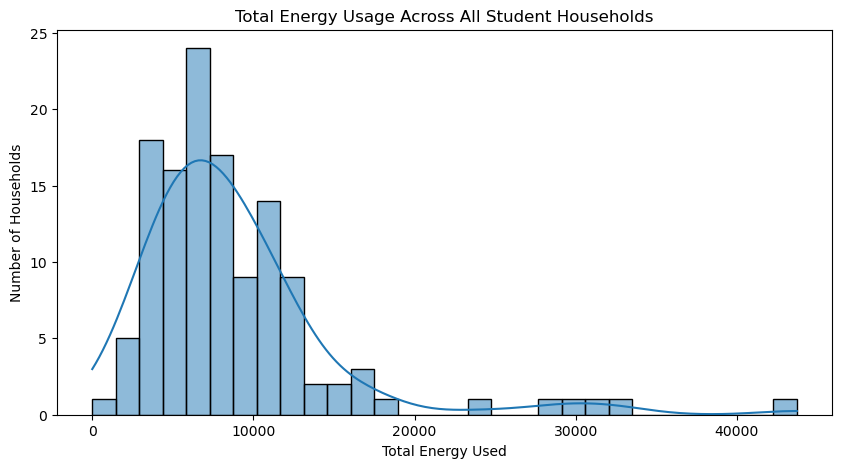

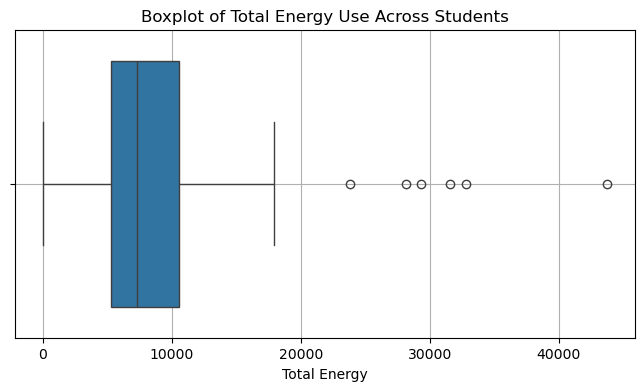

<Figure size 600x600 with 0 Axes>

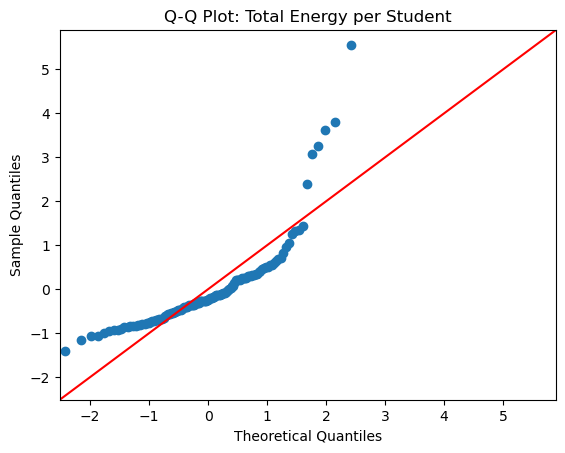


Total Energy per Student Summary:
count      127.000000
mean      8804.820622
std       6320.849902
min          1.037000
25%       5243.967000
50%       7278.357000
75%      10526.277000
max      43713.724000
Name: Total Energy, dtype: float64

Shapiro-Wilk Test: stat=0.7473, p=1.679e-13
The energy usage is not a normal distribution.
D'Agostino-Pearson Test: stat=95.5854, p=1.753e-21
The energy usage is not a normal distribution.


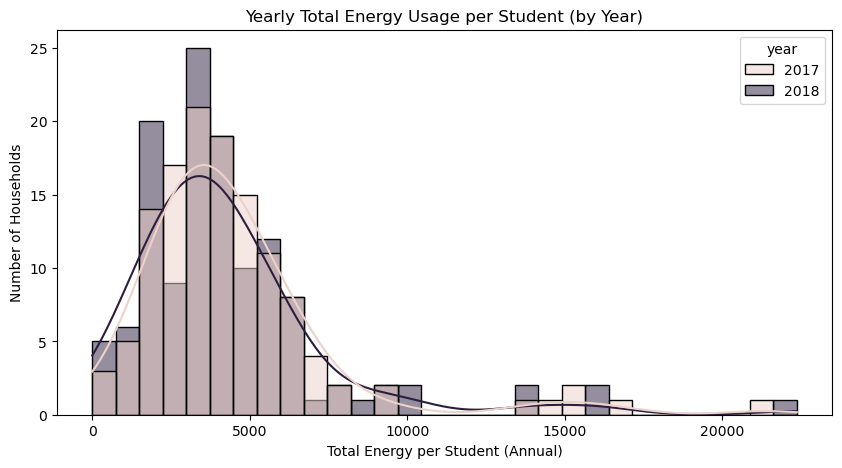

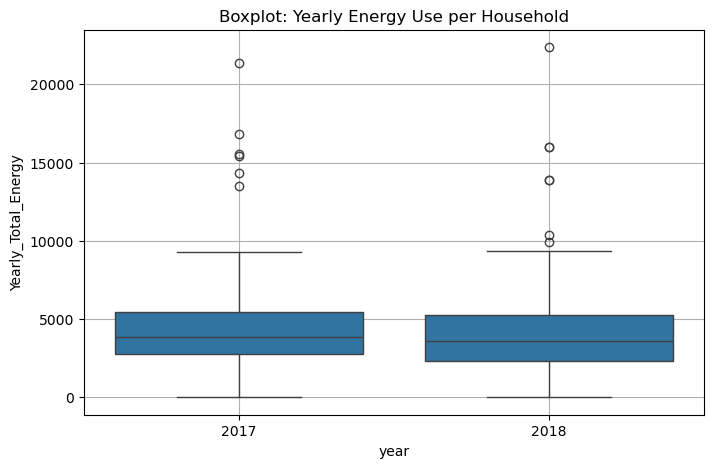

<Figure size 600x600 with 0 Axes>

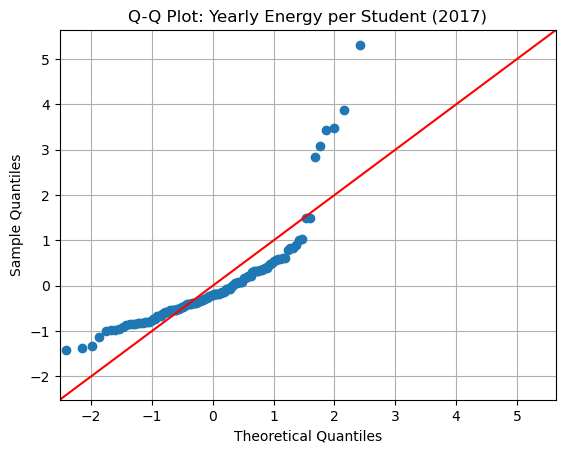

<Figure size 600x600 with 0 Axes>

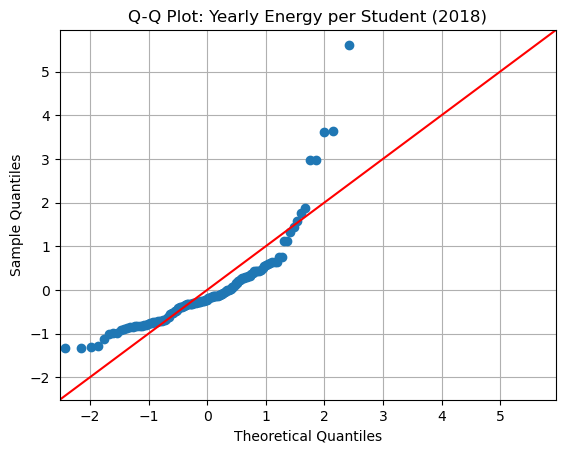


Yearly Energy per Student Summary:
      count         mean          std    min        25%       50%        75%  \
year                                                                           
2017  127.0  4496.410598  3189.325285  0.548  2777.3485  3847.033  5462.2445   
2018  127.0  4308.410024  3237.392378  0.489  2313.9035  3591.262  5259.8825   

            max  
year             
2017  21343.506  
2018  22370.218  


In [38]:
# Analysis of Energy Data
# Target variable: energy
# Population: Student households

student_energy = student_energy.reset_index(drop=True)

print("\nEnergy data\n")
print(student_energy.info())
print(student_energy.head())
print(student_energy.describe().compute())

# Create a new dataframe with the energy consumption statistics
# for each student household

student_energy_statistics = pd.DataFrame()
student_energy_statistics["bmg_id"] = (
    student_energy["bmg_id"].unique().compute()
)

student_energy = student_energy.assign(
    year=student_energy["recorded_timestamp"].dt.year,
    month=student_energy["recorded_timestamp"].dt.month,
)

student_energy_statistics = (
    student_energy.groupby(["bmg_id", "year", "month"])
    .agg(
        **{
            "Total Energy": pd.NamedAgg(column="energy", aggfunc="sum"),
            "Mean Energy": pd.NamedAgg(column="energy", aggfunc="mean"),
            "Median Energy": pd.NamedAgg(column="energy", aggfunc="median"),
            "Min Energy": pd.NamedAgg(column="energy", aggfunc="min"),
            "Max Energy": pd.NamedAgg(column="energy", aggfunc="max"),
            "Std Energy": pd.NamedAgg(column="energy", aggfunc="std"),
        }
    )
    .compute()
    .reset_index()
)

print("\nEnergy Statistic\n")
print(student_energy_statistics.info())
print(student_energy_statistics.head())
print(student_energy_statistics.describe())


# Visualise the total energy distribution in 2017 and 2018
# We are interested in understanding the energy usage over time (Monthly energy consumption over the two-year period)
# 1. Total energy use across all student households
total_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Total Energy"]
    .sum()
    .reset_index()
    .rename(columns={"Total Energy": "Total Energy"})
)

avg_daily_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Mean Energy"]
    .mean()
    .reset_index()
    .rename(columns={"Mean Energy": "Avg_Daily_Energy"})
)

# Plot: Histogram of total energy usage across households
plt.figure(figsize=(10, 5))
sns.histplot(total_energy_per_student["Total Energy"], bins=30, kde=True)
plt.title("Total Energy Usage Across All Student Households")
plt.xlabel("Total Energy Used")
plt.ylabel("Number of Households")
plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=total_energy_per_student["Total Energy"])
plt.title("Boxplot of Total Energy Use Across Students")
plt.grid(True)
plt.show()

# Q-Q plot for yearly total energy
plt.figure(figsize=(6, 6))
sm.qqplot(total_energy_per_student["Total Energy"], line="45", fit=True)
plt.title("Q-Q Plot: Total Energy per Student")
plt.show()

# Summary statistics
print("\nTotal Energy per Student Summary:")
print(total_energy_per_student["Total Energy"].describe())

# Normality tests
stat, p = shapiro(total_energy_per_student["Total Energy"])
print(f"\nShapiro-Wilk Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

stat, p = normaltest(total_energy_per_student["Total Energy"])
print(f"D'Agostino-Pearson Test: stat={stat:.4f}, p={p:.4g}")
print(
    "The energy usage is not a normal distribution."
    if p < 0.10
    else "The energy usage is a normal distribution."
)

# 2. Energy use per household over time (yearly)
per_student_per_year = (
    student_energy_statistics.groupby(["bmg_id", "year"])["Total Energy"]
    .sum()
    .reset_index()
    .rename(columns={"Total Energy": "Yearly_Total_Energy"})
)

plt.figure(figsize=(10, 5))
sns.histplot(
    data=per_student_per_year,
    x="Yearly_Total_Energy",
    hue="year",
    bins=30,
    kde=True,
)
plt.title("Yearly Total Energy Usage per Student (by Year)")
plt.xlabel("Total Energy per Student (Annual)")
plt.ylabel("Number of Households")
plt.show()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=per_student_per_year, x="year", y="Yearly_Total_Energy")
plt.title("Boxplot: Yearly Energy Use per Household")
plt.grid(True)
plt.show()

# Q-Q plot for yearly total energy
years = per_student_per_year["year"].unique()

for y in sorted(years):
    plt.figure(figsize=(6, 6))
    subset = per_student_per_year[per_student_per_year["year"] == y][
        "Yearly_Total_Energy"
    ]
    sm.qqplot(subset, line="45", fit=True)
    plt.title(f"Q-Q Plot: Yearly Energy per Student ({y})")
    plt.grid(True)
    plt.show()

# Descriptive statistics
print("\nYearly Energy per Student Summary:")
print(per_student_per_year.groupby("year")["Yearly_Total_Energy"].describe())

**Inferences**

- From the above histograms, Q-Q plots and box plots, we can visually see that the energy distribution across all student households is right-tailed or skewed.

- From the descriptive statistics, we see that the mode > median> mean. From the Shapiro-Wilk and D'Agostino-Pearson, we see that the distribution is not normal. 

- Therefore, to further carry out inferential statistical tests, we must use non-parametric testing. 

- The inferential statistical analysis is undertaken to understand the impacts of various household parameters, such as the number of bedrooms, appliances, etc., on the energy consumption of a student household.

### Isolate Survey Households

- Isolate the survey data for the required student households
- Use the median energy (a better indicator for right-tailed data) for inferential analysis
- Survey metrics:
    - Household Ownership
    - Landlord Type        
    - Green Energy         
    - Economy System Type             
    - Gas Supply           
    - Smart Meter          
    - Meter Reading Frequency 
    - Primary Heating      
    - EV                   
    - Property Type        
    - Occupancy
    - Main Heating System  
    - Water Heating System 
    - Appliances           
    - Number of Appliances 
     

In [39]:
# Filter the student household survey to reflect the student households
# in the energy data. This ensures the population is the same.
student_ids = student_energy["bmg_id"].unique().compute()
student_survey = student_survey[
    student_survey["bmg_id"].isin(student_ids.str[-9:])
]
id_map = pd.DataFrame({"last9": student_ids.str[-9:], "full_id": student_ids})
student_survey = student_survey.merge(
    id_map, left_on="bmg_id", right_on="last9", how="left"
)
student_survey["bmg_id"] = student_survey["full_id"]
student_survey = student_survey.drop(columns=["last9", "full_id"])

print(student_survey.head())
print(student_survey.info())
print(student_survey.describe())

# Add the median energy and total usage across both years to the
# Survey data
median_energy_per_student = (
    student_energy_statistics.groupby("bmg_id")["Median Energy"]
    .median()
    .reset_index()
)

print(median_energy_per_student)

# Combine the survey data with median energy usage (target variable)
student_survey = student_survey.merge(median_energy_per_student, on="bmg_id")
student_survey = student_survey.merge(total_energy_per_student, on="bmg_id")
print(student_survey.head())

        bmg_id  Occupancy Household Ownership Landlord Type Green Energy  \
0  A2956610843        2.0            Mortgage       Unknown          Yes   
1  A2956611200        1.0                Rent       Council           No   
2  A1956611573        1.0                 Own       Unknown           No   
3  A1956611583        2.0            Mortgage       Unknown           No   
4  A2956611708        1.0                 Own       Unknown           No   

    Eco Type Gas Supply Smart Meter Meter Reading Frequency Primary Heating  \
0    Unknown      Mains     Unknown    Asked to by provider      Gas boiler   
1  Economy 7      Mains          No               Regularly      Gas boiler   
2         No      Mains          No               Regularly      Gas boiler   
3         No      Mains          No             When billed      Gas boiler   
4         No      Mains          No       Electricity bills      Gas boiler   

   EV  Property Type  Number of bedrooms  \
0  No  Semi detached    

### Inferential Statistics

- For categorical data
    - Kruskall Wallis Test
    - Mann-Whitney U Pairwise Testing
- For continuous data
    - Spearman's Correlation

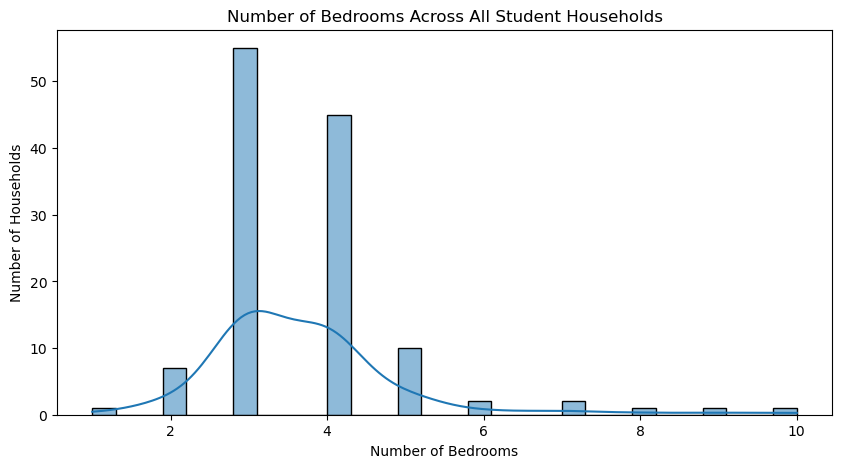

Kruskal-Wallis statistic: 20.8090, p-value: 0.0077
There is a statistically significant difference in median energy usage.
    Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
19      3.0      6.0          0.0  0.001253           0.056391   
25      4.0      6.0          0.0  0.001850           0.083256   
18      3.0      5.0        125.0  0.006564           0.295388   
11      2.0      5.0         10.0  0.013575           0.610860   
4       1.0      6.0          0.0  0.666667           1.000000   
0       1.0      2.0          1.0  0.500000           1.000000   
2       1.0      4.0          1.0  0.086957           1.000000   
1       1.0      3.0          5.0  0.214286           1.000000   
7       1.0      9.0          0.0  1.000000           1.000000   
8       1.0     10.0          0.0  1.000000           1.000000   
9       2.0      3.0        163.0  0.526934           1.000000   
10      2.0      4.0        101.0  0.135580           1.000000   
12      2.0      6.

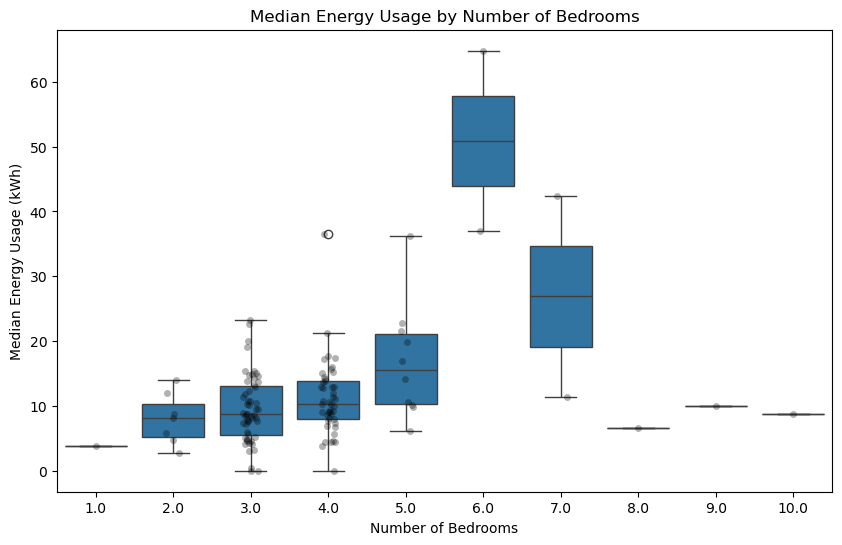

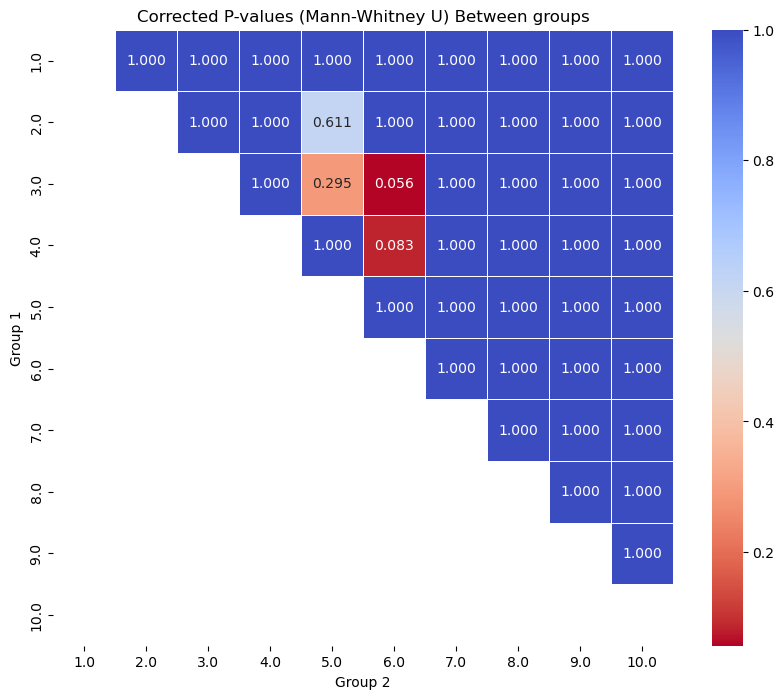

In [40]:
# Number of Bedrooms
# Visualise the distribution of households with each bedroom
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Number of bedrooms"], bins=30, kde=True)
plt.title("Number of Bedrooms Across All Student Households")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Households")
plt.show()

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Number of bedrooms"] == i]["Median Energy"]
    for i in range(1, 10)
    if not student_survey[student_survey["Number of bedrooms"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two  groups have the same distribution of energy usage.
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
bedroom_groups = sorted(student_survey["Number of bedrooms"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(bedroom_groups, 2):
    data1 = student_survey[student_survey["Number of bedrooms"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Number of bedrooms"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Number of bedrooms", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Number of bedrooms",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Number of Bedrooms")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Number of Bedrooms")
plt.show()

# Create an empty DataFrame to store corrected p-values
bedroom_levels = sorted(student_survey["Number of bedrooms"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=bedroom_levels, columns=bedroom_levels)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

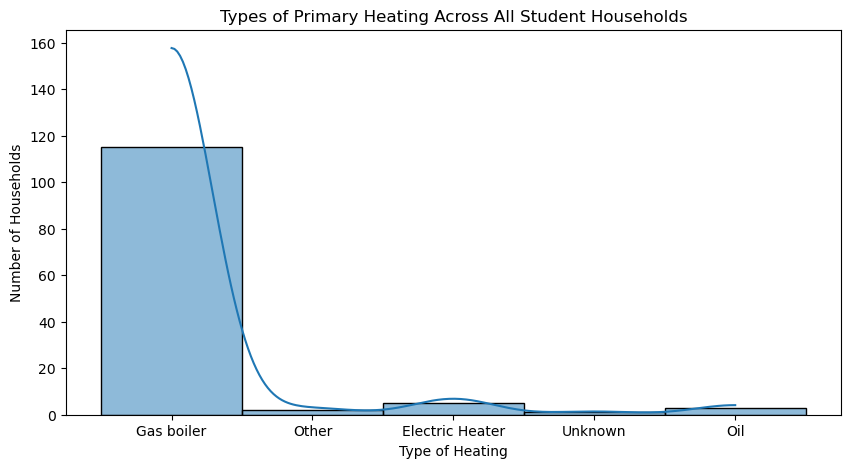

Kruskal-Wallis statistic: 9.2161, p-value: 0.0559
There is a statistically significant difference in median energy usage.
           Group 1     Group 2  U Statistic   P-value  Corrected P-value  \
4       Gas boiler         Oil          0.0  0.003276           0.032757   
1  Electric Heater         Oil          0.0  0.035714           0.357143   
2  Electric Heater       Other          5.0  1.000000           1.000000   
0  Electric Heater  Gas boiler        287.0  1.000000           1.000000   
3  Electric Heater     Unknown          2.0  1.000000           1.000000   
5       Gas boiler       Other        107.0  0.874689           1.000000   
6       Gas boiler     Unknown         33.0  0.473535           1.000000   
7              Oil       Other          6.0  0.200000           1.000000   
8              Oil     Unknown          3.0  0.500000           1.000000   
9            Other     Unknown          1.0  1.000000           1.000000   

   Reject Null (α=0.1)  
4               

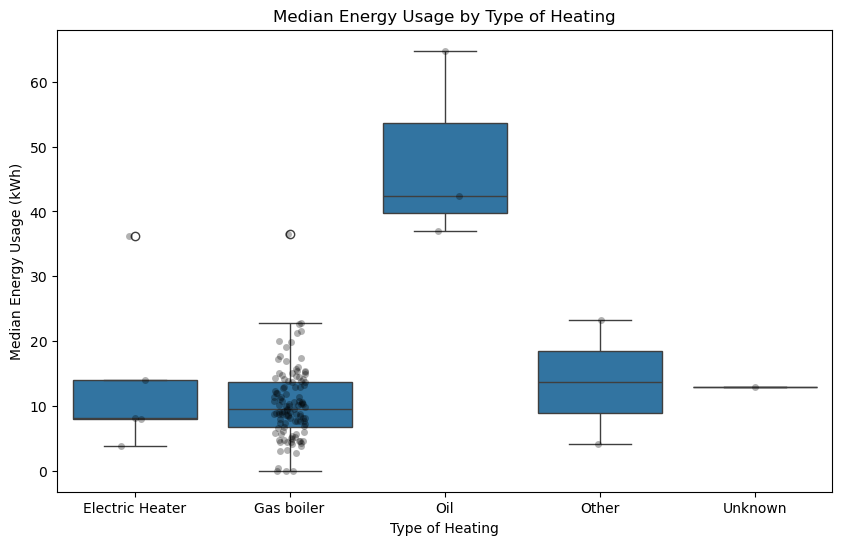

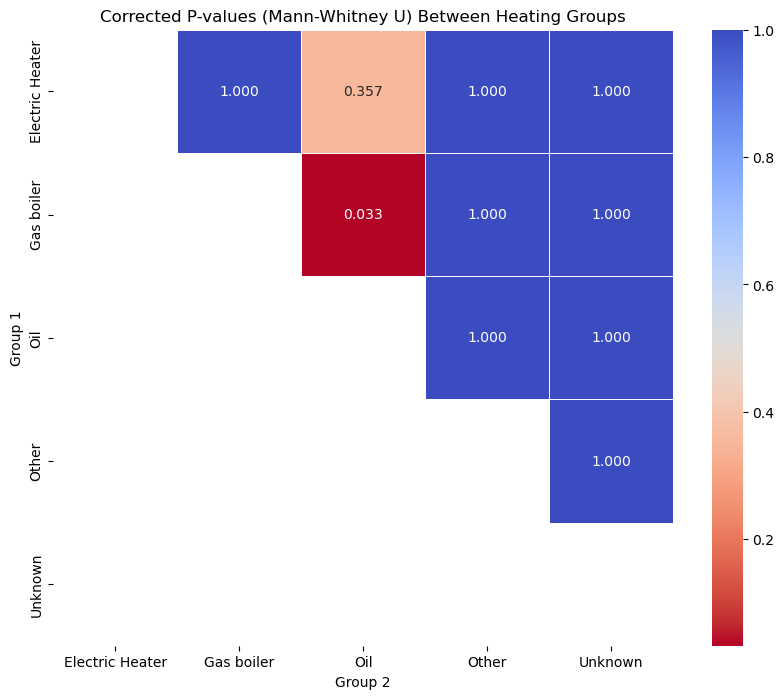

In [41]:
# Types of Primary Heating
# Visualise the distribution of households with each type of Primary Heating
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Primary Heating"], bins=30, kde=True)
plt.title("Types of Primary Heating Across All Student Households")
plt.xlabel("Type of Heating")
plt.ylabel("Number of Households")
plt.show()

student_survey["Primary Heating"] = student_survey["Primary Heating"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Primary Heating"] == i]["Median Energy"]
    for i in student_survey["Primary Heating"].cat.categories
    if not student_survey[student_survey["Primary Heating"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
heating_groups = sorted(student_survey["Primary Heating"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(heating_groups, 2):
    data1 = student_survey[student_survey["Primary Heating"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Primary Heating"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.1)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Primary Heating", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Primary Heating",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Heating")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Heating")
plt.show()

# Create an empty DataFrame to store corrected p-values
heating_types = sorted(student_survey["Primary Heating"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=heating_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Heating Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

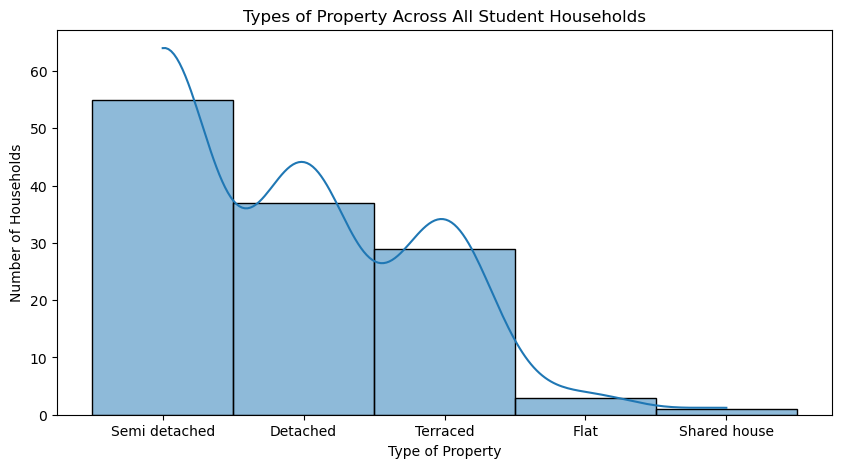

Kruskal-Wallis statistic: 6.3473, p-value: 0.1747
There is no statistically significant difference in median energy usage.
         Group 1        Group 2  U Statistic   P-value  Corrected P-value  \
1       Detached  Semi detached       1252.5  0.061861           0.618613   
0       Detached           Flat         73.0  0.400810           1.000000   
2       Detached   Shared house         36.0  0.105263           1.000000   
3       Detached       Terraced        628.0  0.239717           1.000000   
4           Flat  Semi detached         77.0  0.868810           1.000000   
5           Flat   Shared house          3.0  0.500000           1.000000   
6           Flat       Terraced         35.0  0.623790           1.000000   
7  Semi detached   Shared house         51.0  0.178571           1.000000   
8  Semi detached       Terraced        719.0  0.463052           1.000000   
9   Shared house       Terraced          2.0  0.200000           1.000000   

   Reject Null (α=0.10)  
1  

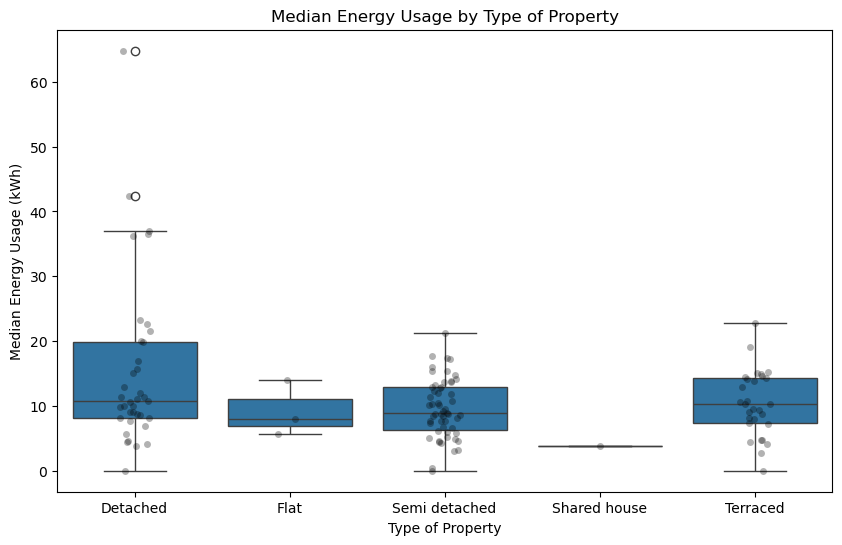

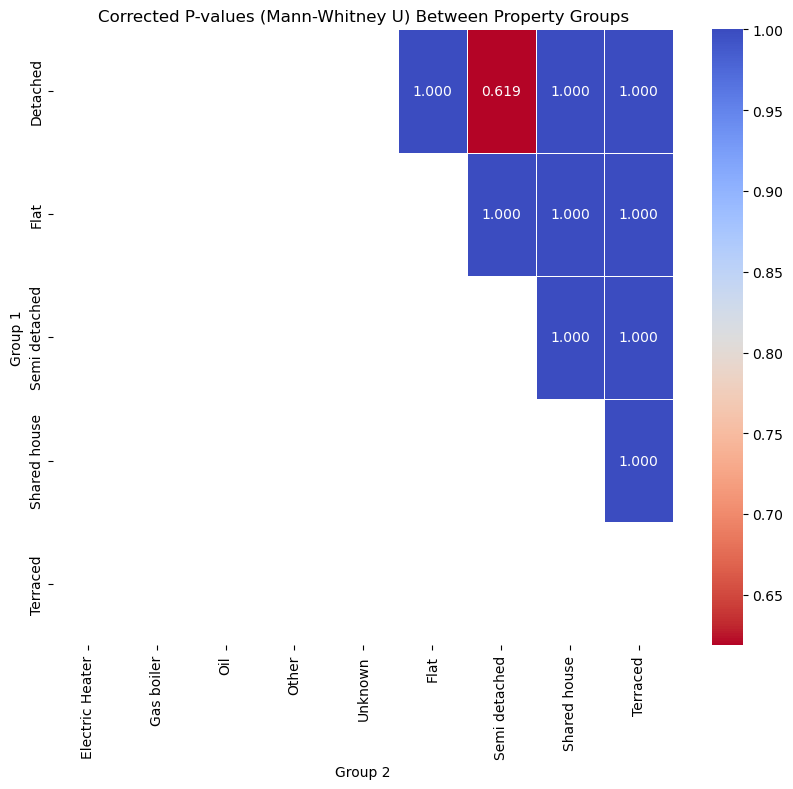

In [42]:
# Types of Property Type
# Visualise the distribution of households with each type of Property Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Property Type"], bins=30, kde=True)
plt.title("Types of Property Across All Student Households")
plt.xlabel("Type of Property")
plt.ylabel("Number of Households")
plt.show()

student_survey["Property Type"] = student_survey["Property Type"].astype(
    "category"
)

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Property Type"] == i]["Median Energy"]
    for i in student_survey["Property Type"].cat.categories
    if not student_survey[student_survey["Property Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
property_groups = sorted(student_survey["Property Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(property_groups, 2):
    data1 = student_survey[student_survey["Property Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Property Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Property Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Property Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Property")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Property")
plt.show()

# Create an empty DataFrame to store corrected p-values
property_types = sorted(student_survey["Property Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=property_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Property Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

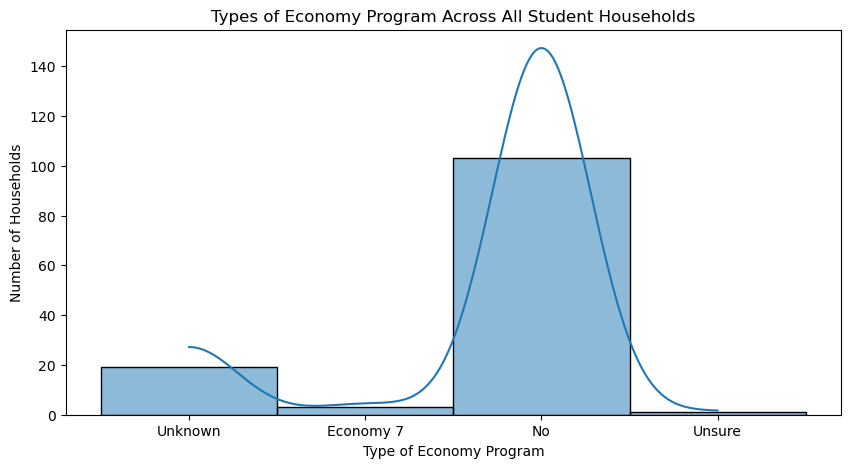

Kruskal-Wallis statistic: 1.9306, p-value: 0.5869
There is no statistically significant difference in median energy usage.
     Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
0  Economy 7       No        207.0  0.338036                1.0   
1  Economy 7  Unknown         39.0  0.355844                1.0   
2  Economy 7   Unsure          1.0  1.000000                1.0   
3         No  Unknown        988.5  0.946521                1.0   
4         No   Unsure         21.0  0.423077                1.0   
5    Unknown   Unsure          6.0  0.700000                1.0   

   Reject Null (α=0.10)  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
5                 False  


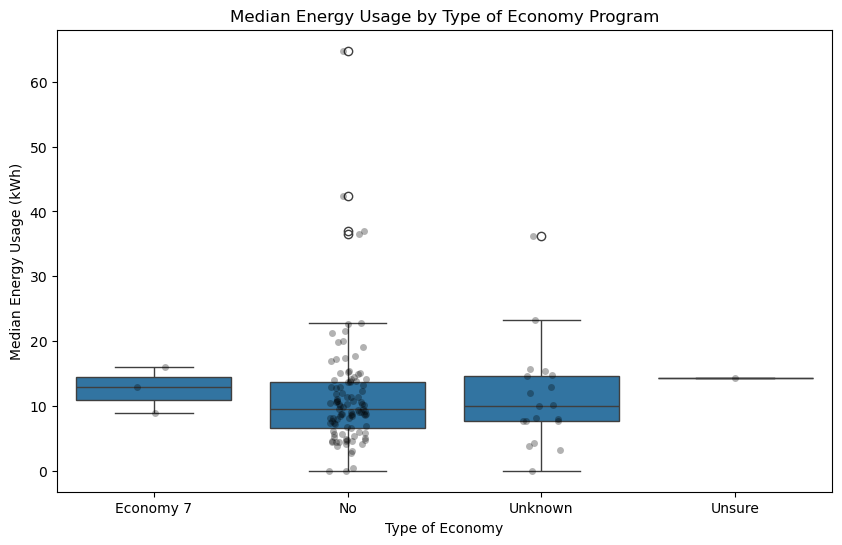

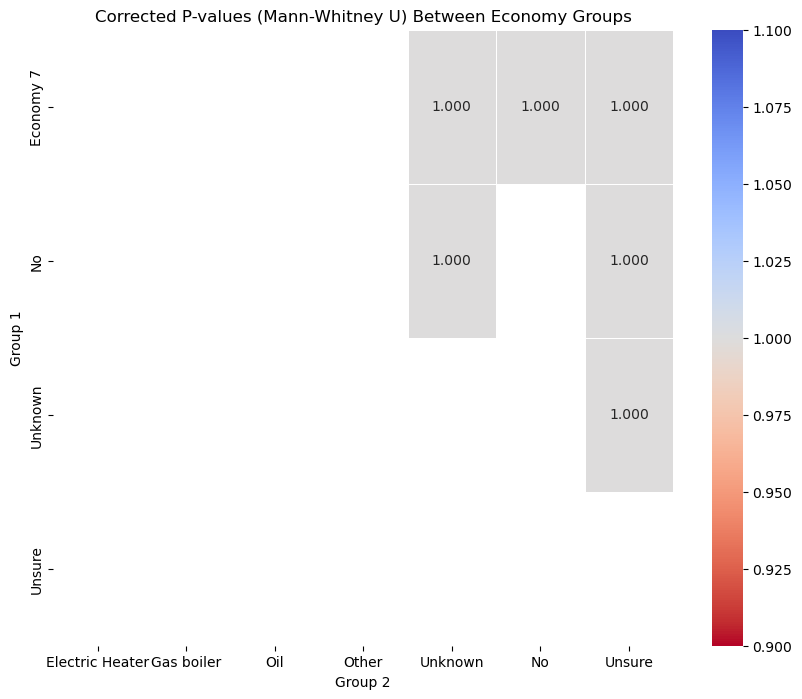

In [43]:
# Types of Eco Type
# Visualise the distribution of households with each type of Eco Type
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Eco Type"], bins=30, kde=True)
plt.title("Types of Economy Program Across All Student Households")
plt.xlabel("Type of Economy Program")
plt.ylabel("Number of Households")
plt.show()

student_survey["Eco Type"] = student_survey["Eco Type"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Eco Type"] == i]["Median Energy"]
    for i in student_survey["Eco Type"].cat.categories
    if not student_survey[student_survey["Eco Type"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
economy_groups = sorted(student_survey["Eco Type"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(economy_groups, 2):
    data1 = student_survey[student_survey["Eco Type"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Eco Type"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Eco Type", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Eco Type",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Type of Economy Program")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Eco Type"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Economy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

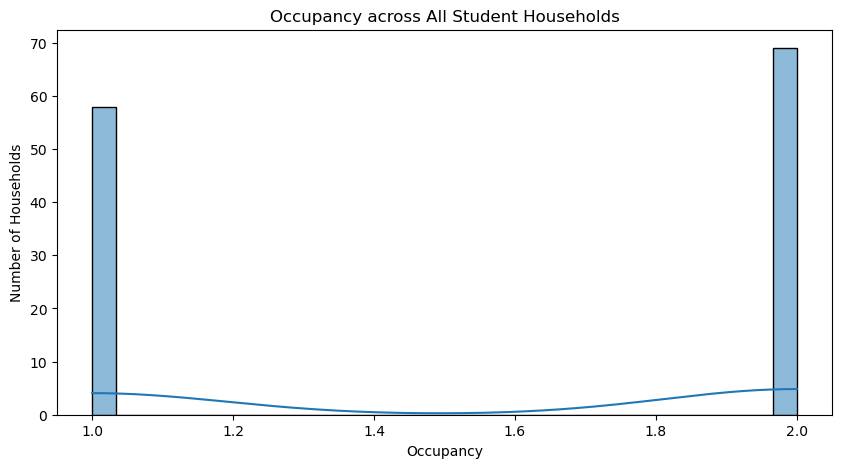

Kruskal-Wallis statistic: 0.5484, p-value: 0.4590
There is no statistically significant difference in median energy usage.
   Group 1  Group 2  U Statistic   P-value  Corrected P-value  \
0      1.0      2.0       2154.0  0.460451           0.460451   

   Reject Null (α=0.10)  
0                 False  


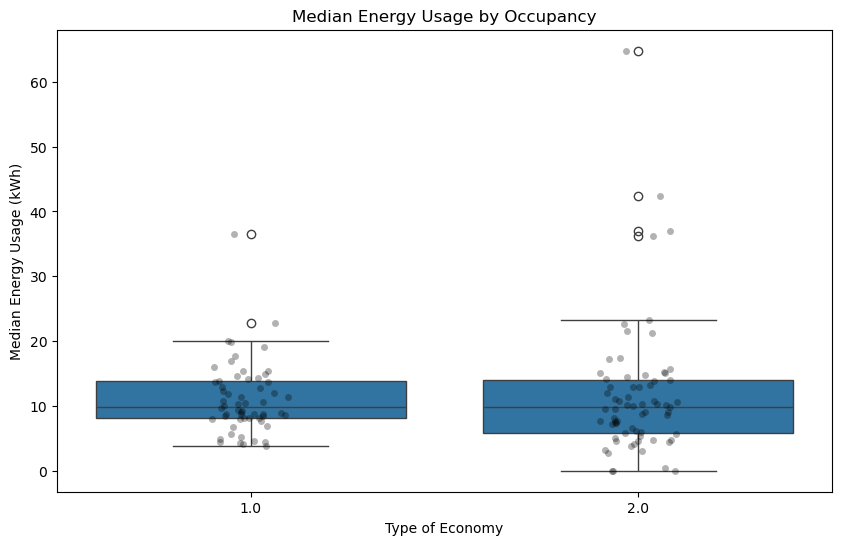

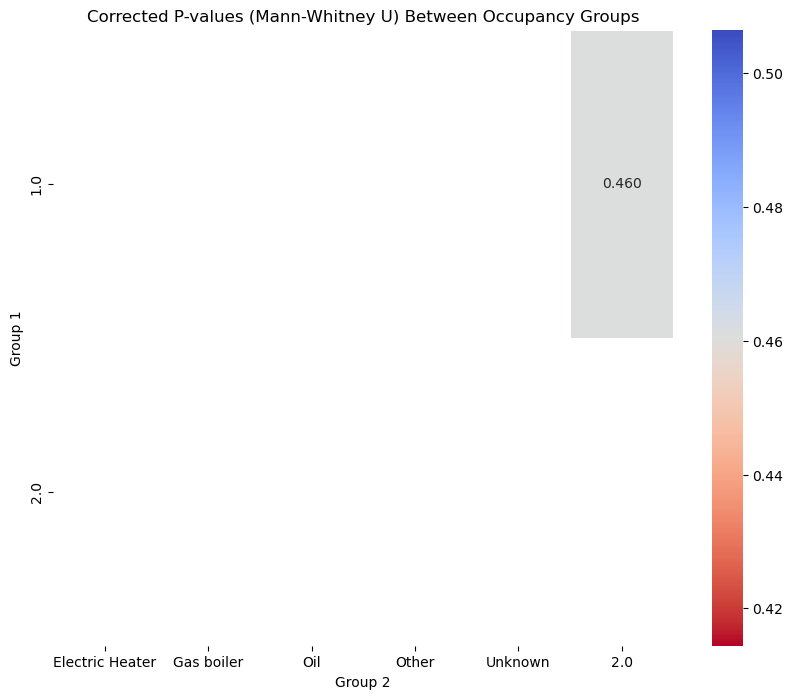

In [44]:
# Types of Occupancy
# Visualise the distribution of households with each type of Occupancy
plt.figure(figsize=(10, 5))
sns.histplot(student_survey["Occupancy"], bins=30, kde=True)
plt.title("Occupancy across All Student Households")
plt.xlabel("Occupancy")
plt.ylabel("Number of Households")
plt.show()

student_survey["Occupancy"] = student_survey["Occupancy"].astype("category")

# Kruskall Wallis Test
samples = [
    student_survey[student_survey["Occupancy"] == i]["Median Energy"]
    for i in student_survey["Occupancy"].cat.categories
    if not student_survey[student_survey["Occupancy"] == i][
        "Median Energy"
    ].empty
]

stat, p = kruskal(*samples)

print(f"Kruskal-Wallis statistic: {stat:.4f}, p-value: {p:.4f}")
if p < 0.10:
    print(
        "There is a statistically significant difference in median energy usage."
    )
else:
    print(
        "There is no statistically significant difference in median energy usage."
    )

# Pairwise Mann-Whitney test
# Null Hypothesis (H₀): The two groups have the same distribution of energy usage (no difference in medians).
# Alternative Hypothesis (H₁): The two groups have different distributions of energy usage.
# Get unique bedroom counts
occupancy_groups = sorted(student_survey["Occupancy"].dropna().unique())

# Prepare a list for results
results = []

# Loop through all pairwise combinations of groups
for group1, group2 in combinations(occupancy_groups, 2):
    data1 = student_survey[student_survey["Occupancy"] == group1][
        "Median Energy"
    ].dropna()
    data2 = student_survey[student_survey["Occupancy"] == group2][
        "Median Energy"
    ].dropna()

    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")
        results.append((group1, group2, stat, p))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results, columns=["Group 1", "Group 2", "U Statistic", "P-value"]
)

# Apply Bonferroni correction
reject, p_corrected, _, _ = multipletests(
    results_df["P-value"], alpha=0.1, method="bonferroni"
)
results_df["Corrected P-value"] = p_corrected
results_df["Reject Null (α=0.10)"] = reject

# Display results
print(results_df.sort_values(by="Corrected P-value"))

plt.figure(figsize=(10, 6))
sns.boxplot(data=student_survey, x="Occupancy", y="Median Energy")
sns.stripplot(
    data=student_survey,
    x="Occupancy",
    y="Median Energy",
    color="black",
    alpha=0.3,
    jitter=True,
)
plt.title("Median Energy Usage by Occupancy")
plt.ylabel("Median Energy Usage (kWh)")
plt.xlabel("Type of Economy")
plt.show()

# Create an empty DataFrame to store corrected p-values
eco_types = sorted(student_survey["Occupancy"].dropna().unique())
p_matrix = pd.DataFrame(np.nan, index=eco_types, columns=heating_types)

# Fill upper triangle with corrected p-values
for _, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p_matrix.loc[g1, g2] = row["Corrected P-value"]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm_r", linewidths=0.5, fmt=".3f")
plt.title("Corrected P-values (Mann-Whitney U) Between Occupancy Groups")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

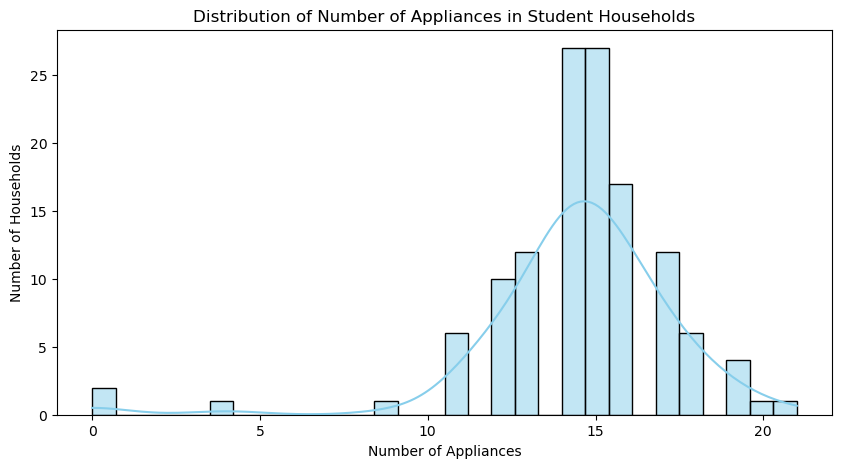

/tmp/ipykernel_8799/1485460987.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


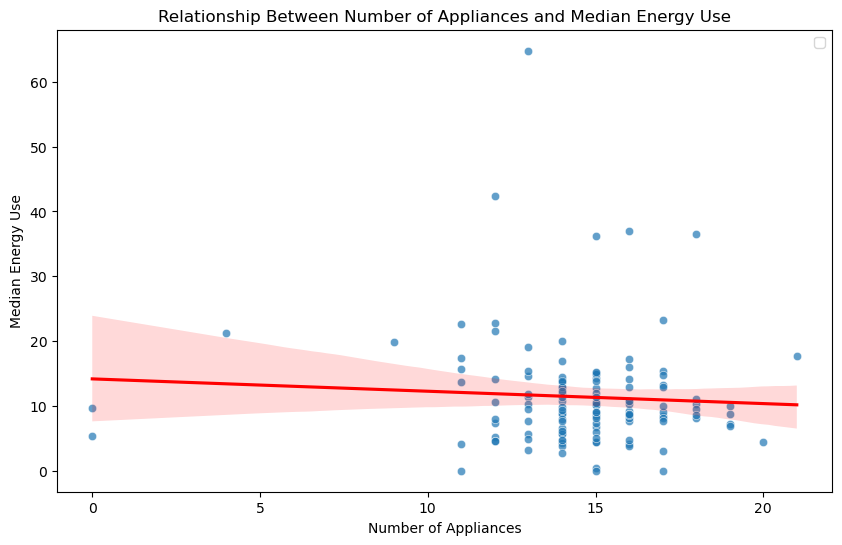

Spearman Correlation: -0.069
P-value: 0.4421
There is no statistically significant correlation.


In [45]:
# Histogram: Distribution of number of appliances
plt.figure(figsize=(10, 5))
sns.histplot(
    student_survey["Number of Appliances"], bins=30, kde=True, color="skyblue"
)
plt.title("Distribution of Number of Appliances in Student Households")
plt.xlabel("Number of Appliances")
plt.ylabel("Number of Households")
plt.show()

# Scatterplot: Median Energy vs. Number of Appliances
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=student_survey, x="Number of Appliances", y="Median Energy", alpha=0.7
)
sns.regplot(  # Optional: add a trend line
    data=student_survey,
    x="Number of Appliances",
    y="Median Energy",
    scatter=False,
    color="red",
    line_kws={"label": "Linear Trend"},
)
plt.title("Relationship Between Number of Appliances and Median Energy Use")
plt.xlabel("Number of Appliances")
plt.ylabel("Median Energy Use")
plt.legend()
plt.show()

# Spearman's correlation
stat, pvalue = spearmanr(
    student_survey["Median Energy"], student_survey["Number of Appliances"]
)
print(f"Spearman Correlation: {stat:.3f}")
print(f"P-value: {pvalue:.4f}")

if pvalue < 0.10:
    print("There is a statistically significant correlation.")
else:
    print("There is no statistically significant correlation.")

In [46]:
client.shutdown()